In [9]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sma
import warnings

In [11]:
#Setting Training and Test Sets
option_dict = {}
option_dict['ortho'] = False
option_dict['start_date'] = '1965-07-31'
option_dict['end_date'] = '2010-12-31'
option_dict['oos_date'] = '1985-07-31'
for key,value in option_dict.items():
    print(key,'\t',value)

ortho 	 False
start_date 	 1965-07-31
end_date 	 2010-12-31
oos_date 	 1985-07-31


In [29]:
# Ignore UserWarning related to header or footer parsing in Excel files
warnings.filterwarnings("ignore", message="Cannot parse header or footer so it will be ignored")
# Data preprocessing - WG_df
WG_df = pd.read_excel('PredictorData2020.xlsx', sheet_name='Monthly', header=0)
# Rename the column 'yyyymm' to 'date' for clarity
WG_df.rename(columns={'yyyymm': 'date'}, inplace=True)
# Convert the 'date' column to datetime format and set it to the month's end
WG_df['date'] = pd.to_datetime(WG_df['date'], format='%Y%m') + MonthEnd(0)
# Set 'date' as the DataFrame index
WG_df.set_index('date', drop=True, inplace=True)
# Filter data based on the provided date range in option_dict
WG_df = WG_df.loc[option_dict['start_date']:option_dict['end_date']]
# Calculate LogRx: log(1 + CRSP_SPvw) - log(1 + Rfree)
WG_df['LogRx'] = np.log1p(WG_df['CRSP_SPvw']) - np.log1p(WG_df['Rfree'])
# Calculate Rx: CRSP_SPvw - Rfree
WG_df['Rx'] = WG_df['CRSP_SPvw'] - WG_df['Rfree']
# Print the first 3 rows to check the processed data
print(WG_df.head(3))

            Index      D12      E12        BM     TBL     AAA     BAA     LTY  \
date                                                                            
1965-07-31  85.25  2.62667  4.88667  0.473382  0.0384  0.0448  0.0488  0.0424   
1965-08-31  87.17  2.64333  4.93333  0.467361  0.0384  0.0449  0.0488  0.0428   
1965-09-30  89.96  2.66000  4.98000  0.448537  0.0392  0.0452  0.0491  0.0433   

                NTIS   Rfree  ...        DP        DY        EP        DE  \
date                          ...                                           
1965-07-31  0.015627  0.0031  ... -3.479871 -3.466527 -2.859077 -0.620794   
1965-08-31  0.015601  0.0033  ... -3.495821 -3.473549 -2.871846 -0.623975   
1965-09-30  0.016895  0.0031  ... -3.521039 -3.489534 -2.893935 -0.627104   

               TMS     DFY     DFR        Rm     LogRx        Rx  
date                                                              
1965-07-31  0.0040  0.0040 -0.0402  4.442488  0.011287  0.011386  
1965-08

In [35]:
# Suppress warnings from openpyxl
warnings.filterwarnings("ignore", message="Unknown extension is not supported and will be removed")
# Data preprocessing - BW_df
BW_df = pd.read_excel('Investor_Sentiment_Data_20190327_POST.xlsx', sheet_name='DATA', header=0)
# Replace "." with NaN for missing values (without triggering the FutureWarning)
BW_df.replace(".", np.nan, regex=True, inplace=True)
# Explicitly convert object columns to their appropriate types to avoid the warning
BW_df = BW_df.apply(pd.to_numeric, errors='ignore')  # Convert columns to numeric where possible
# Rename the column 'yearmo' to 'date' for clarity
BW_df.rename(columns={'yearmo': 'date'}, inplace=True)
# Convert 'date' to datetime format and set it to the month's end
BW_df['date'] = pd.to_datetime(BW_df['date'], format='%Y%m') + MonthEnd(0)
# Filter data for dates between '1963-07-31' and '2010-12-31' and set 'date' as the index
BW_df = BW_df.query("'1963-07-31' <= date <= '2010-12-31'").set_index('date', drop=True)
# Calculate growth rates for industrial production, employment, and consumption
BW_df['gIndpro'] = BW_df['indpro'] / BW_df['indpro'].shift(12) - 1
BW_df['gEmploy'] = BW_df['employ'] / BW_df['employ'].shift(12) - 1
BW_df['gConsdur'] = (BW_df['consdur'] / BW_df['consdur'].shift(12)) / (BW_df['cpi'] / BW_df['cpi'].shift(12)) - 1
BW_df['gConsnon'] = (BW_df['consnon'] / BW_df['consnon'].shift(12)) / (BW_df['cpi'] / BW_df['cpi'].shift(12)) - 1
BW_df['gConsserv'] = (BW_df['consserv'] / BW_df['consserv'].shift(12)) / (BW_df['cpi'] / BW_df['cpi'].shift(12)) - 1
# Print the first 3 rows to verify
print(BW_df.head(3))

            SENT^   SENT       pdnd  ripo  nipo  cefd      eqti  Unnamed: 8  \
date                                                                          
1963-07-31     NaN   NaN  24.425216  -1.3   6.0   NaN  0.115720         NaN   
1963-08-31     NaN   NaN  24.067530   1.2   7.0   NaN  0.119039         NaN   
1963-09-30     NaN   NaN  23.696115   3.5   8.0   NaN  0.110274         NaN   

             indpro  consdur  consnon  consserv  recess  employ   cpi  \
date                                                                    
1963-07-31  27.7203     55.5    144.7     184.3       0   56794  30.7   
1963-08-31  27.7756     54.1    146.5     185.7       0   56910  30.7   
1963-09-30  28.0526     54.6    144.3     186.6       0   57078  30.7   

            gIndpro  gEmploy  gConsdur  gConsnon  gConsserv  
date                                                         
1963-07-31      NaN      NaN       NaN       NaN        NaN  
1963-08-31      NaN      NaN       NaN       NaN    

/var/folders/zl/pfg03yts3kd5b7pxx10r8dy00000gn/T/ipykernel_9364/513844862.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  BW_df.replace(".", np.nan, regex=True, inplace=True)
/var/folders/zl/pfg03yts3kd5b7pxx10r8dy00000gn/T/ipykernel_9364/513844862.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  BW_df = BW_df.apply(pd.to_numeric, errors='ignore')  # Convert columns to numeric where possible


In [37]:
# Extract relevant macroeconomic variables into a new DataFrame
Macro_df = BW_df[['gIndpro', 'gEmploy', 'gConsdur', 'gConsnon', 'gConsserv', 'recess']]
# Filter the macroeconomic variables for the date range 1965-07-31 to 2010-12-31
Macro1_df = Macro_df.loc['1965-07-31':'2010-12-31']
# Create a new DataFrame with macroeconomic variables lagged by 12 months
Macro2_df = Macro_df.shift(12).loc['1965-07-31':'2010-12-31']

In [39]:
# Create an empty DataFrame called BW_proxy_df
BW_proxy_df = pd.DataFrame(None)
# Negate the values of 'pdnd' and 'cefd' columns from BW_df and assign them to BW_proxy_df
BW_proxy_df[['pdnd', 'cefd']] = -BW_df[['pdnd', 'cefd']]
# Calculate the rolling sum over a 12-month window (with at least one data point) for the 'pdnd' column
BW_proxy_df['pdnd'] = BW_proxy_df['pdnd'].rolling(window=12, min_periods=1).sum()
# Calculate the rolling sum over a 12-month window (with at least one data point) for the 'cefd' column
BW_proxy_df['cefd'] = BW_proxy_df['cefd'].rolling(window=12, min_periods=1).sum()
# Calculate the rolling sum for the 'eqti' column from BW_df over a 12-month window
BW_proxy_df['eqti'] = BW_df['eqti'].rolling(window=12, min_periods=1).sum()
# Calculate the rolling sum for the 'nipo' column from BW_df over a 12-month window
BW_proxy_df['nipo'] = BW_df['nipo'].rolling(window=12, min_periods=1).sum()
# Compute a weighted rolling average for the 'ripo' column:
# (1) Multiply 'ripo' by 'nipo' from BW_df, then take the rolling sum
# (2) Divide the result by the rolling sum of 'nipo' (to normalize by total 'nipo')
BW_proxy_df['ripo'] = (BW_df['ripo'] * BW_df['nipo']).rolling(window=12, min_periods=1).sum() / \
    BW_df['nipo'].rolling(window=12, min_periods=1).sum()
# Shift the 'pdnd' and 'ripo' columns down by one row (lagging these values by one time period)
BW_proxy_df[['pdnd', 'ripo']] = BW_proxy_df[['pdnd', 'ripo']].shift()
# Filter the DataFrame to only include rows between the specified 'start_date' and 'end_date' from option_dict
BW_proxy_df = BW_proxy_df.loc[option_dict['start_date']:option_dict['end_date']]
# Print the first 5 rows of the resulting DataFrame (this line is commented out)
print(BW_proxy_df.head(5))

                  pdnd       cefd      eqti   nipo       ripo
date                                                         
1965-07-31 -343.926045 -19.274681  2.398778  124.0  11.974380
1965-08-31 -339.387566 -38.959852  2.320678  121.0  14.280645
1965-09-30 -333.817815 -56.536697  2.241562  130.0  16.422314
1965-10-31 -327.379547 -70.130848  2.150454  133.0  14.863077
1965-11-30 -318.181729 -84.091031  2.072099  145.0  13.959398


In [41]:
# Extract return data from WG_df for the columns 'LogRx' and 'Rx'
Ret_df = WG_df[['LogRx', 'Rx']]
# Define the target column name for the return data
Ret_target_name = 'LogRx'
# Extract the target return data ('LogRx') into a new DataFrame
target_R_df = Ret_df[[Ret_target_name]]
# Print the first 5 rows of the target return data (this line is commented out)
target_R_df.head(5)

,LogRx
date,
1965-07-31,0.011287
1965-08-31,0.023892
1965-09-30,0.029726
1965-10-31,0.025310
1965-11-30,-0.007322


In [45]:
# Select specific columns from BW_proxy_df and combine with Macro1_df
var1 = ['cefd', 'eqti', 'nipo']
BWvar1 = BW_proxy_df[var1]
BWvar1 = pd.concat([BWvar1, Macro1_df], axis=1)
# Select other specific columns from BW_proxy_df and combine with Macro2_df
var2 = ['pdnd', 'ripo']
BWvar2 = BW_proxy_df[var2]
BWvar2 = pd.concat([BWvar2, Macro2_df], axis=1)
# Combine selected columns from BWvar1 and BWvar2 into a single DataFrame
BWvar_df = pd.concat([BWvar1[var1], BWvar2[var2]], axis=1)
# Create an ExcelWriter object to save data into an Excel file
writer = pd.ExcelWriter('Sentiment data processing IS_OOS.xlsx', engine='openpyxl')
# Write each DataFrame to a separate sheet in the Excel file
BW_proxy_df.to_excel(writer, sheet_name='BW proxy')
Macro1_df.to_excel(writer, sheet_name='Macro1')
Macro2_df.to_excel(writer, sheet_name='Macro2')
Ret_df.to_excel(writer, sheet_name='Ret')
# Close the writer to save the file
writer.close()

In [47]:
BW_proxy_df = pd.read_excel('Sentiment data processing IS_OOS.xlsx', sheet_name = 'BW proxy')
BW_proxy_df['date'] = pd.to_datetime(BW_proxy_df['date'])
BW_proxy_df.set_index('date',drop=True, inplace=True)
#print(BW_proxy_df. head(3))

Macro1_df = pd.read_excel('Sentiment data processing IS_OOS.xlsx', sheet_name ='Macro1')
Macro1_df['date'] = pd.to_datetime(Macro1_df['date'])
Macro1_df.set_index('date',drop=True,inplace=True)
#print(Macro1_df.head(3))

Macro2_df = pd.read_excel('Sentiment data processing IS_OOS.xlsx', sheet_name ='Macro2')
Macro2_df['date'] = pd.to_datetime(Macro2_df['date'])
Macro2_df.set_index('date',drop=True,inplace=True)
#print(Macro2_df.head(3))

Ret_df = pd.read_excel('Sentiment data processing IS_OOS.xlsx', sheet_name ='Ret')
Ret_df['date'] = pd.to_datetime(Ret_df['date'])
Ret_df.set_index('date',drop=True,inplace=True)
#print(Ret_df.head(3))

In [49]:
var1 = ['cefd','eqti','nipo']
var2 = ['pdnd','ripo']
Ret_target_name = 'LogRx'
target_R_df = Ret_df[[Ret_target_name]]

BWvar1 = BW_proxy_df[var1]
BWvar1 = pd.concat([BWvar1, Macro1_df],axis=1)
#print(BWvar1.head(3))

BWvar2 = BW_proxy_df[var2]
BWvar2 = pd.concat( [BWvar2, Macro2_df], axis =1)
#print(BWvar2. head(3))

BWvar_df = pd.concat( [BWvar1[var1], BWvar2[var2]],axis=1)
#print(BWvar_df.head(3))
BWvar_df

,cefd,eqti,nipo,pdnd,ripo
date,,,,,
1965-07-31,-19.274681,2.398778,124,-343.926045,11.974380
1965-08-31,-38.959852,2.320678,121,-339.387566,14.280645
1965-09-30,-56.536697,2.241562,130,-333.817815,16.422314
1965-10-31,-70.130848,2.150454,133,-327.379547,14.863077
1965-11-30,-84.091031,2.072099,145,-318.181729,13.959398
...,...,...,...,...,...
2010-08-31,-109.910000,2.774998,154,40.464655,6.558042
2010-09-30,-108.200000,2.779832,157,43.210952,7.353247
2010-10-31,-104.520000,2.797755,169,48.020265,7.256688


In [51]:
Var_df = BWvar_df
Var_df = Var_df.apply(zscore,ddof=1)
target_R = target_R_df
#target_R
Reg_df = pd.concat([target_R.shift(-1), Var_df],axis =1)
Reg_df = Reg_df.iloc[:-1]
#Reg_df

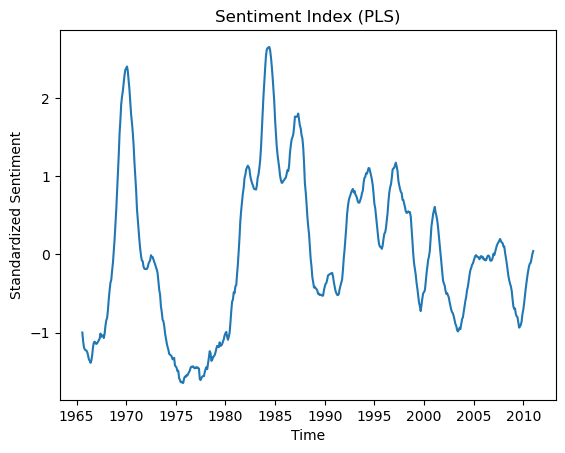

In [63]:
def PLS2step(target_R, Var_df, R_target_name):
    """
    Perform a two-step Partial Least Squares (PLS) regression to calculate a sentiment index.
    
    Parameters:
    - target_R: DataFrame containing the target variable (e.g., returns).
    - Var_df: DataFrame containing the independent variables (predictors).
    - R_target_name: Name of the target variable column in target_R.
    
    Returns:
    - PLS_df: A DataFrame containing the calculated sentiment index (standardized).
    """

    # Combine lagged target variable (shifted by -1) with predictors
    Reg_df = pd.concat([target_R.shift(-1), Var_df], axis=1)
    Reg_df = Reg_df.iloc[:-1]  # Drop the last row (to handle NaN after shifting)

    # Initialize dictionary to store first-step regression coefficients
    out = {}

    # First-step regression: Regress each predictor on the target variable
    for col in Var_df.columns:
        result = smf.ols(formula=f"{col} ~ {R_target_name}", data=Reg_df).fit(cov_type='HAC', cov_kwds={'maxlags': 0})
        out[col] = result.params.iloc[1]  # Use `.iloc` to explicitly access by position

    # Convert the collected coefficients into a DataFrame
    out_df = pd.DataFrame(out, columns=Var_df.columns, index=[0])

    # Initialize PLS DataFrame to store the sentiment index
    PLS_df = pd.DataFrame(None, index=Var_df.index, columns=['Sent'])

    # Second-step regression: Calculate the sentiment index for each time step
    for ind in Var_df.index:
        # Prepare data for regression (combine predictor values with first-step coefficients)
        data_df = pd.concat([Var_df.loc[ind].T, out_df.T], axis=1)
        data_df.columns = ['Y', 'X']
        
        # Perform regression for second step
        result = smf.ols(formula='Y ~ X', data=data_df).fit()
        
        # Use `.iloc` to access the intercept value explicitly
        PLS_df.loc[ind, 'Sent'] = result.params.iloc[0]  # Access intercept explicitly

    # Standardize the sentiment index (mean=0, std=1)
    PLS_df['Sent'] = (PLS_df['Sent'] - PLS_df['Sent'].mean()) / PLS_df['Sent'].std()

    return PLS_df

# Call the function to compute the sentiment index
SentiPLS_df = PLS2step(target_R, Var_df, Ret_target_name)

# Plot the sentiment index
plt.plot(SentiPLS_df)
plt.title("Sentiment Index (PLS)")
plt.xlabel("Time")
plt.ylabel("Standardized Sentiment")
plt.show()

# (Optional) Output the sentiment index to an Excel file
# SentiPLS_df.to_excel('PLS.xlsx')

In [65]:
def pls(xs, rm, standardize=True):
    """
    Partial Least Squares (PLS) two-stage regression for calculating a sentiment index.

    Parameters:
    - xs: ndarray, shape (T, N), represents T days and N sentiment indicators.
    - rm: ndarray, shape (T,) or (T, 1), represents T days of stock returns.
    - standardize: bool, whether to standardize the sentiment index (mean=0, std=1).

    Returns:
    - sent: ndarray, shape (T,), the calculated sentiment index as a one-dimensional array.
    """
    T, N = xs.shape  # T: number of days, N: number of sentiment indicators

    # Step 1: Regression of each sentiment indicator on stock returns (rm)
    pis = np.ones((N, 2))  # Coefficients for the first-stage regression, shape (N, 2)
    rm = sma.add_constant(rm)  # Add a constant term (intercept) to stock returns (rm)
    
    for n in range(N):
        # Use data up to T-1 for sentiment indicator (xs) and from day 1 onward for stock returns (rm)
        x = xs[:-1, n].ravel()  # Reshape the sentiment indicator to a 1D array
        r = rm[1:, :]  # Use stock returns from day 1 onward, shape (T-1, 2)
        
        # Perform regression: x ~ r (sentiment indicator ~ stock returns)
        result = sma.OLS(x, r).fit()
        pi = result.params[1]  # Extract the coefficient of the stock returns (rm)
        pis[n, 1] = pi  # Store the coefficient in pis[:, 1]

    # Step 2: Cross-sectional regression for sentiment index calculation
    ss = np.ones(T)  # Coefficients for the second-stage regression, shape (T,)
    
    for t in range(T):
        # Perform regression for each day t: sentiment indicators ~ coefficients from the first stage
        x = xs[t, :]  # Use sentiment indicators for day t, shape (N,)
        result = sma.OLS(x, pis).fit()
        ss[t] = result.params[1]  # Extract the coefficient for the sentiment index

    # Step 3: Standardize the sentiment index (if required)
    if standardize:
        sent = (ss - np.mean(ss)) / np.std(ss)  # Standardize to have mean=0 and std=1
    else:
        sent = ss

    # Return the calculated sentiment index as a 1D array
    return sent

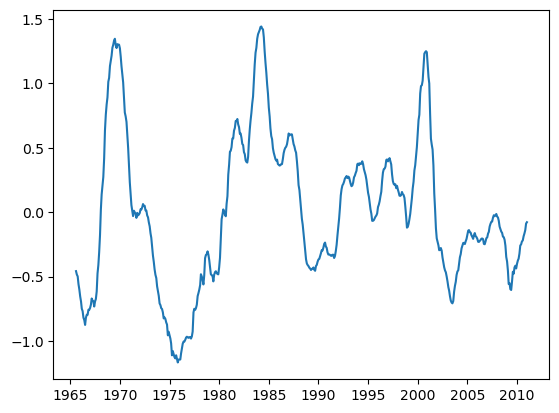

In [67]:
#EW
def EW_Senti(Var_df):
    #Var_df = Var_df.apply(zscore,ddof=1)
    #Var_df = pd.DataFrame(Var_df)
    cols = Var_df.columns
    Var_df['Sent'] = Var_df[cols].mean(axis=1)
    return Var_df[['Sent']] 
                   
Senti_dfEW = EW_Senti(Var_df)
plt.plot(Senti_dfEW)
#Senti_dfEW.to_excel('EW.xlsx')

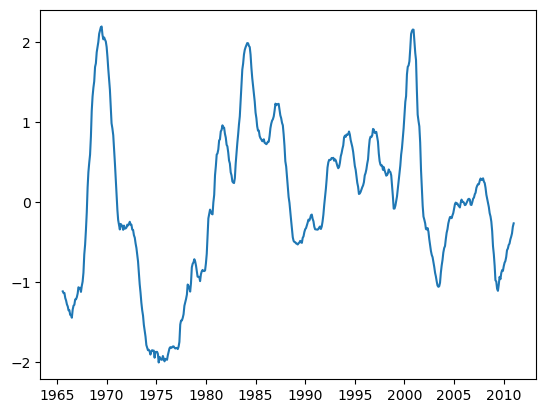

In [69]:
#BW
def BW_Senti(Var_df): 
    #Var_df = Var_df.apply(zscore,ddof=1) 
    #print(Var_df.head(10)) 
    pca =PCA(svd_solver='full') 
    score=pca.fit_transform(Var_df)
    #print(score)
    Var_df ['Sent']=zscore(score[:,0]) 
    return Var_df[['Sent']] 

SentiBW_df=BW_Senti(Var_df)
plt.plot(SentiBW_df)
#SentiBW_df.to_excel('BW.xlsx')

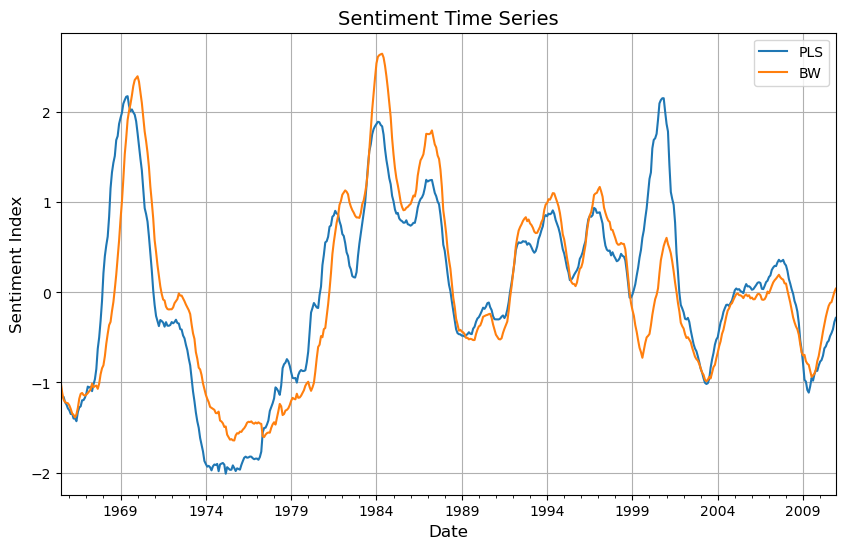

In [73]:
#Figure 1
# Load data from Excel
sentiment_df = pd.read_excel('data1.xlsx', sheet_name='Monthly', header=0)

# Rename the date column
sentiment_df.rename(columns={'yyyymm': 'date'}, inplace=True)

# Convert the date column to datetime format and set as index
try:
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], format='%Y%m') + MonthEnd(0)
    sentiment_df.set_index('date', drop=True, inplace=True)
except Exception as e:
    print("Error in date conversion:", e)

# Plot the selected columns (18th and 19th)
try:
    sentiment_df.iloc[:, 18:20].dropna().plot(figsize=(10, 6))
    plt.title('Sentiment Time Series', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sentiment Index', fontsize=12)
    plt.legend(['PLS', 'BW'], fontsize=10)
    plt.grid(True)
    plt.show()
except Exception as e:
    print("Error in plotting:", e)

In [75]:
#Table 1 DescriptiveStatistics
data = sentiment_df.copy()
data = data.select_dtypes(include=[np.number])
# Descriptive statistics
table1 = data.describe()
# Compute skewness and kurtosis
s = data.skew()
k = data.kurt()
# Add skewness and kurtosis as rows in the descriptive statistics table
table1.loc['skew'] = s
table1.loc['kurtosis'] = k
# Round the results for better readability
table1 = table1.round(2)
# Print the table for confirmation
print(table1)

             TBL     LTY    NTIS    INFL     LTR    SVAR      DP      DY  \
count     546.00  546.00  546.00  546.00  546.00  546.00  546.00  546.00   
mean        0.05    0.07    0.01    0.00    0.01    0.00   -3.56   -3.56   
std         0.03    0.02    0.02    0.00    0.03    0.00    0.42    0.42   
min         0.00    0.03   -0.06   -0.02   -0.11    0.00   -4.52   -4.53   
25%         0.04    0.05    0.00    0.00   -0.01    0.00   -3.93   -3.93   
50%         0.05    0.07    0.01    0.00    0.01    0.00   -3.49   -3.49   
75%         0.07    0.08    0.03    0.01    0.02    0.00   -3.27   -3.26   
max         0.16    0.15    0.05    0.02    0.15    0.07   -2.75   -2.75   
skew        0.72    0.90   -0.83   -0.13    0.40    9.88   -0.37   -0.38   
kurtosis    1.35    0.36    0.79    3.91    2.58  122.52   -0.76   -0.74   

              EP      DE     TMS     DFY     DFR      Rf      Rm     CAY  \
count     546.00  546.00  546.00  546.00  546.00  546.00  546.00  546.00   
mean       

In [77]:
#Define the saliency labeling function
def signif(result,i):
    beta=str(round(result.params[i]*100,2))
    p=result.pvalues[i]
    if p>=0.05 and p<0.1:
        beta=beta+'*'
    elif p>=0.01 and p<0.05:
        beta=beta+'**'
    elif p<0.01:
        beta=beta+'***'
    return beta

In [79]:
#Defining the R2 function
def R2c(y,result,dummy):
    resid=result.resid.values
    if resid.size<500:
        y=y[y.size-resid.size:]
    r1=(resid**2)*dummy
    r2=((y-y.mean())**2)*dummy
    R2=1-r1.sum()/r2.sum()
    return round(R2*100,2)

In [81]:
#Table 2 In-sample forecasts
# Load the dataset from an Excel file
table_2_df = pd.read_excel('data2.xlsx', header=0, index_col=0)

# Select sentiment indicators, market return, and recession indicator columns
df_sent = table_2_df[['PDND', 'CEFD', 'EQTI', 'NIPO', 'RIPO', 'BW', 'PLS', 'PLS_F', 'EW']]  # Sentiment indicators
df_ret = table_2_df[['Rm']]  # Stock market returns
df_rec = table_2_df[['Recess']]  # Recession indicator

# Define the list of sentiment indicators to be used for regression
sents = ['CEFD', 'NIPO', 'RIPO', 'PDND', 'EQTI', 'BW', 'EW', 'PLS', 'PLS_F', 'Kitchen sink']

# Lag sentiment indicators by one period to avoid look-ahead bias
df1 = df_sent.shift(1)  # Shift all sentiment indicators by one period

# Merge lagged sentiment indicators with stock market returns
df_ols2 = df1.merge(df_ret, left_index=True, right_index=True)

# Drop a specific problematic data point (e.g., index 196507)
df_ols2.drop(index=196507, inplace=True)

# Define the dependent variable (stock market returns)
y = df_ols2['Rm']

# Initialize lists to store regression results
results = []  # Stores regression model results
betas = []  # Stores the coefficients (beta) for each sentiment indicator
ts = []  # Stores t-statistics for each sentiment indicator
R2s = []  # Stores R-squared values for each regression

# Perform OLS regression for each sentiment indicator
for sent in sents:
    if sent == 'Kitchen sink':  # If using multiple indicators in one model
        x = sma.add_constant(df_ols2.loc[:, sents[0:5]])  # Use the first 5 sentiment indicators
    else:
        x = sma.add_constant(df_ols2[sent])  # Use a single sentiment indicator
        
    # Build and fit the OLS regression model
    model = sma.OLS(y, x, missing='drop')
    result = model.fit()
    
    # Extract beta (coefficient) and significance if not "Kitchen sink"
    if sent == 'Kitchen sink':
        beta = ''  # Skip beta for "Kitchen sink"
    else:
        beta = signif(result, 1)  # Function to format beta with significance stars
    
    # Extract t-statistic if not "Kitchen sink"
    if sent == 'Kitchen sink':
        t = ''  # Skip t-statistic for "Kitchen sink"
    else:
        t = round(result.tvalues[1], 2)  # Round t-statistic to 2 decimal places
    
    # Extract R-squared value and convert to percentage
    R2 = round(result.rsquared * 100, 2)
    
    # Append results to corresponding lists
    results.append(result)
    betas.append(beta)
    ts.append(t)
    R2s.append(R2)

# Create a DataFrame to store the regression results
table2 = pd.DataFrame(
    index=sents,
    columns=['beta(%)', 't-stat', 'R2(%)', 'R2_up(%)', 'R2_down(%)', 'R2_high(%)', 'R2_low(%)']
)
table2['beta(%)'] = betas  # Add beta coefficients to the table
table2['t-stat'] = ts  # Add t-statistics to the table
table2['R2(%)'] = R2s  # Add R-squared values to the table

# Merge the recession indicator (lagged by one period) with the regression dataset
df_ols3 = df_ols2.merge(df_rec.shift(1), left_index=True, right_index=True)

# Define variables for recession periods
rec_down = df_ols3['Recess'].values  # Recession periods
rec_up = rec_down + 1  # Expansion periods
rec_up[rec_up == 2] = 0  # Ensure binary values (0 for expansion, 1 for recession)

# Initialize lists for R-squared values in different periods
R2_ups = []  # R-squared during expansion periods
R2_downs = []  # R-squared during recession periods

# Define variables for high and low sentiment periods
nlen = len(df_ols3.loc[df_ols3['PLS_F'].isnull()])  # Count missing values for PLS_F
sent = df_ols3['PLS']  # Use PLS as the main sentiment index
sent_me = sent.median()  # Median sentiment value as the threshold
sent_high = np.array(sent >= sent_me)  # High sentiment periods
sent_low = np.array(sent < sent_me)  # Low sentiment periods

R2_highs = []  # R-squared during high sentiment periods
R2_lows = []  # R-squared during low sentiment periods

# Calculate R-squared values for different periods
for result in results:
    # Handle the shorter sample size for PLS_F
    if results.index(result) == len(results) - 2:  # If it's the second-to-last result
        rec_up1 = rec_up[nlen:]  # Adjust expansion period array
        rec_down1 = rec_down[nlen:]  # Adjust recession period array
        sent_high1 = sent_high[nlen:]  # Adjust high sentiment array
        sent_low1 = sent_low[nlen:]  # Adjust low sentiment array
    else:
        rec_up1 = rec_up  # Use full arrays
        rec_down1 = rec_down
        sent_high1 = sent_high
        sent_low1 = sent_low
    
    # Calculate R-squared values for each period
    R2_up = R2c(y, result, rec_up1)  # Expansion period
    R2_down = R2c(y, result, rec_down1)  # Recession period
    R2_high = R2c(y, result, sent_high1)  # High sentiment period
    R2_low = R2c(y, result, sent_low1)  # Low sentiment period
    
    # Append R-squared values to corresponding lists
    R2_ups.append(R2_up)
    R2_downs.append(R2_down)
    R2_highs.append(R2_high)
    R2_lows.append(R2_low)

# Add R-squared values for different periods to the results table
table2['R2_up(%)'] = R2_ups  # Expansion
table2['R2_down(%)'] = R2_downs  # Recession
table2['R2_high(%)'] = R2_highs  # High sentiment
table2['R2_low(%)'] = R2_lows  # Low sentiment

# Save the table to an Excel file (optional)
# table2.to_excel('Table2.xlsx')

# Print the results table
pd.set_option('display.width', 1000)  # Set display width for better table readability
print(table2)  # Print the final table

               beta(%) t-stat  R2(%)  R2_up(%)  R2_down(%)  R2_high(%)  R2_low(%)
CEFD             -0.08  -0.43   0.03      0.01        0.10        0.04       0.02
NIPO              0.02   0.09   0.00      0.00        0.00        0.01      -0.01
RIPO            -0.32*   -1.7   0.53      0.62        0.29        0.58       0.44
PDND             -0.03  -0.14   0.00      0.01       -0.02       -0.01       0.03
EQTI             -0.11  -0.58   0.06      0.13       -0.10        0.03       0.11
BW               -0.17  -0.96   0.17      0.19        0.13        0.11       0.25
EW               -0.29  -0.92   0.16      0.21        0.01        0.06       0.30
PLS           -0.67***  -3.57   2.30      2.03        2.96        2.50       2.00
PLS_F            -0.14  -0.65   0.10     -0.07        0.64        0.10       0.10
Kitchen sink                    1.04      0.99        1.15        1.28       0.68


/var/folders/zl/pfg03yts3kd5b7pxx10r8dy00000gn/T/ipykernel_9364/2121979323.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta=str(round(result.params[i]*100,2))
/var/folders/zl/pfg03yts3kd5b7pxx10r8dy00000gn/T/ipykernel_9364/2121979323.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p=result.pvalues[i]
/var/folders/zl/pfg03yts3kd5b7pxx10r8dy00000gn/T/ipykernel_9364/1403681705.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

In [83]:
#Table 3 Predictions including tests
# Import the necessary function for the t-test
from scipy.stats import t  # Import t-distribution for the MDM test

# Define the MDM test function
def MDM(result1, result2):
    """
    Perform the Modified Diebold-Mariano (MDM) test to compare two models.
    
    Parameters:
    - result1: The first regression result (statsmodels OLS result object).
    - result2: The second regression result (statsmodels OLS result object).
    
    Returns:
    - pvalue: The one-tailed p-value of the MDM test (rounded to 2 decimal places).
    """
    # Calculate residuals (errors) for both models
    e1 = result1.resid
    e2 = result2.resid
    
    # Compute the difference-in-residuals term
    d = (e1 - e2) * e1  # Weighted residuals based on the first model's residuals
    
    # Calculate the MDM statistic
    dm = d.mean() / d.std()  # Mean divided by standard deviation of d
    n = result1.nobs  # Number of observations in the first model
    mdm = (((n - 1) / n) ** 0.5) * dm  # MDM statistic as per the formula in the paper
    
    # Compute the p-value using the t-distribution
    pvalue = t.sf(mdm, n - 1)  # Survival function (1-CDF) for a one-tailed test
    
    return round(pvalue, 2)  # Return the p-value rounded to 2 decimal places


# Generate Table 3: Pairwise comparison of predictive power
table3 = pd.DataFrame(index=sents[:-2], columns=sents[:-2])  # Exclude the last two variables ('PLS_F' and 'Kitchen sink')

# Use the regression results from Table 2
results = results[:-2][:]  # Exclude the last two models (e.g., 'PLS_F' and 'Kitchen sink')

# Perform pairwise comparisons of predictive power
for i in range(len(results)):
    result2s = results[:]  # Create a copy of the results list
    result1 = result2s.pop(i)  # Remove the i-th model (self-comparison is not allowed)
    pvalues = []  # Initialize a list to store p-values
    
    # Compare the i-th model with all other models
    for result2 in result2s:
        pvalue = MDM(result1, result2)  # Perform the MDM test
        pvalues.append(pvalue)  # Append the p-value to the list
    
    # Insert a blank space (' ') in the diagonal (self-comparison)
    pvalues.insert(i, ' ')
    
    # Assign the p-values to the i-th row of the table
    table3.iloc[i, :] = pvalues

# Save the table to an Excel file (optional)
# table3.to_excel('Table3.xlsx')

# Print Table 3
print(table3)  # Display the comparison table for predictive power

      CEFD NIPO  RIPO PDND  EQTI    BW    EW   PLS
CEFD        0.5  0.47  0.5  0.49  0.49  0.49  0.44
NIPO  0.49       0.47  0.5  0.49  0.49  0.49  0.44
RIPO   0.5  0.5        0.5   0.5   0.5   0.5  0.45
PDND  0.49  0.5  0.47       0.49  0.49  0.48  0.44
EQTI  0.49  0.5  0.47  0.5        0.49  0.49  0.44
BW     0.5  0.5  0.48  0.5   0.5         0.5  0.44
EW     0.5  0.5  0.48  0.5   0.5   0.5        0.44
PLS    0.5  0.5  0.48  0.5   0.5   0.5   0.5      


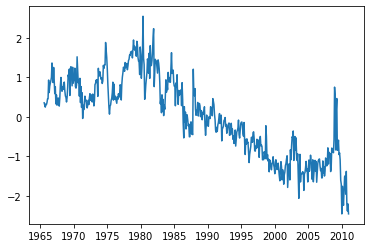

In [39]:
df_econ = pd.read_excel('ECON.xlsx',header = 0,index_col=0)
df_econ = df_econ.apply(zscore,ddof=1)
#df_econ
df_ols4=df_ols2.loc[:,['Rm','PLS']].merge(df_econ.shift(1),left_index=True,right_index=True)
y=df_ols4['Rm']

#构造ECON_PC预测指标，这里采用主成分分析方法
econs=df_ols4.loc[:,df_econ.columns].values
model=PCA(n_components=1,whiten=True)
model.fit(econs)
df_ols4['ECON_PC']=model.transform(econs)
#df_ols4.to_excel('df_ols4.xlsx')
#df_ols4.xlsx包含ECON_PC

#构造ECON_PLS预测指标，这里采用PLS方法
df_econ1 = pd.read_excel('ECON.xlsx',header = 0)
df_econ1.rename(columns = {'yyyymm':'date'},inplace = True)
df_econ1['date'] = pd.to_datetime(df_econ1['date'],format = '%Y%m') + MonthEnd(0)
df_econ1.set_index('date',drop=True,inplace=True)
SentiPLS1_df = PLS2step(target_R,df_econ1,Ret_target_name)
plt.plot(SentiPLS1_df)
#SentiPLS1_df.to_excel('ECON_PLS.xlsx')
#ECON_PLS.xlsx包含ECON_PLS

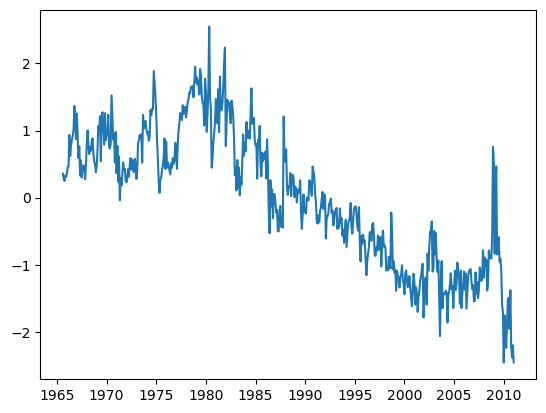

In [87]:
# Load economic data from an Excel file
df_econ = pd.read_excel('ECON.xlsx', header=0, index_col=0)

# Standardize the economic data using z-scores
# The zscore function standardizes each column (mean=0, std=1)
df_econ = df_econ.apply(zscore, ddof=1)

# Merge the lagged economic data and the sentiment index (PLS) with stock returns (Rm)
df_ols4 = df_ols2.loc[:, ['Rm', 'PLS']].merge(df_econ.shift(1), left_index=True, right_index=True)

# Define the dependent variable (stock returns)
y = df_ols4['Rm']

# Construct the ECON_PC predictor using Principal Component Analysis (PCA)
econs = df_ols4.loc[:, df_econ.columns].values  # Extract economic variables as a NumPy array
model = PCA(n_components=1, whiten=True)  # Initialize PCA with 1 component and whitening enabled
model.fit(econs)  # Fit the PCA model to the economic data
df_ols4['ECON_PC'] = model.transform(econs)  # Transform the data and add the first principal component to the DataFrame

# Optional: Save the resulting DataFrame to an Excel file for inspection
# df_ols4.to_excel('df_ols4.xlsx') 
# The saved file will include the derived ECON_PC variable.

# Construct the ECON_PLS predictor using the Partial Least Squares (PLS) method
# Reload the economic data for PLS processing
df_econ1 = pd.read_excel('ECON.xlsx', header=0)

# Rename the date column for consistency
df_econ1.rename(columns={'yyyymm': 'date'}, inplace=True)

# Convert the 'date' column to a proper datetime format (YYYY-MM) and set it as the index
df_econ1['date'] = pd.to_datetime(df_econ1['date'], format='%Y%m') + MonthEnd(0)
df_econ1.set_index('date', drop=True, inplace=True)

# Use the custom-defined PLS2step function to compute the ECON_PLS predictor
# target_R: The target variable (e.g., stock returns)
# df_econ1: The economic data
# Ret_target_name: Name of the returns column in df_econ1
SentiPLS1_df = PLS2step(target_R, df_econ1, Ret_target_name)

# Plot the ECON_PLS predictor for visualization
plt.plot(SentiPLS1_df)

# Optional: Save the resulting ECON_PLS predictor to an Excel file
# SentiPLS1_df.to_excel('ECON_PLS.xlsx') 
# The saved file will include the derived ECON_PLS variable.

In [89]:
#Table 4A Univariate Prediction Regression Compared with Economic Variables
# Load the dataset from an Excel file
df_ols4 = pd.read_excel('data3.xlsx', header=0, index_col=0)

# Initialize lists to store regression results
psis = []  # Stores the coefficients (psi) of each economic indicator
ts = []  # Stores the t-statistics of each economic indicator
R2s = []  # Stores the R² values for each regression

# Define the economic predictors (columns starting from the 3rd column onward in df_ols4)
econ_pre = df_ols4.columns[2:]

# Loop through each economic indicator and perform OLS regression
for econ in econ_pre:
    # Add a constant term (intercept) to the independent variable
    x = sma.add_constant(df_ols4[econ])  # Economic indicator as the independent variable
    
    # Build the OLS regression model
    model = sma.OLS(y, x, missing='drop')  # y is the dependent variable (defined earlier in your script)
    result = model.fit()  # Fit the OLS model
    
    # Extract the coefficient and significance for the economic indicator
    psi = signif(result, 1)  # Function to format the coefficient and add significance stars
    t = round(result.tvalues[1], 2)  # Extract and round the t-statistic of the economic indicator
    R2 = round(result.rsquared * 100, 2)  # Calculate R² value and convert to a percentage
    
    # Append the results to the corresponding lists
    psis.append(psi)  # Append the coefficient with significance
    ts.append(t)  # Append t-statistic
    R2s.append(R2)  # Append R² value

# Create a DataFrame to store the results for Panel A of Table 4
table4A = pd.DataFrame(index=econ_pre, columns=['psi(%)', 't-stat', 'R2(%)'])
table4A['psi(%)'] = psis  # Add the coefficients to the table
table4A['t-stat'] = ts  # Add the t-statistics to the table
table4A['R2(%)'] = R2s  # Add the R² values to the table

# Save the results to an Excel file
table4A.to_excel('Tabel4A.xlsx')  # Export Table 4 Panel A to an Excel file

# Optional: Save the full data (df_ols4) to an Excel file for inspection
# df_ols4.to_excel('OLS4.xlsx')

# Print the results table for quick inspection
print(table4A)  # Display Table 4 Panel A

             psi(%)  t-stat  R2(%)
DP             0.22    1.14   0.24
DY             0.24    1.26   0.29
EP              0.1    0.53   0.05
DE             0.14    0.72   0.10
SVAR        -0.45**   -2.36   1.01
NTIS           -0.1   -0.51   0.05
TBL           -0.18   -0.92   0.16
LTY            0.01    0.04   0.00
LTR          0.48**    2.54   1.18
TMS           0.35*    1.82   0.61
DFY            0.25    1.33   0.32
DFR          0.38**    1.97   0.71
INFL           -0.3   -1.59   0.46
CAY             0.1    0.52   0.05
CSR           -0.11   -0.55   0.06
OG         -0.56***   -2.94   1.57
ECON_PC        0.03    0.14   0.00
ECON_PLS     -0.4**   -2.11   0.81
SECON_PC       0.02    0.09   0.00
SECON_PLS     -0.09   -0.46   0.04


/var/folders/zl/pfg03yts3kd5b7pxx10r8dy00000gn/T/ipykernel_9364/2121979323.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta=str(round(result.params[i]*100,2))
/var/folders/zl/pfg03yts3kd5b7pxx10r8dy00000gn/T/ipykernel_9364/2121979323.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p=result.pvalues[i]
/var/folders/zl/pfg03yts3kd5b7pxx10r8dy00000gn/T/ipykernel_9364/3259743829.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

In [42]:
#Panel B二元OLS回归
betas=[]
tbs=[]
psis=[]
tps=[]
R2s=[]
#循环做二元回归
for econ in econ_pre:
    x=df_ols4.loc[:,['PLS',econ]]
    x=sma.add_constant(x)
    model=sma.OLS(y,x,missing='drop')
    result=model.fit()
    beta=signif(result,1)#情绪指标的系数，并带上了显著性
    tb=round(result.tvalues[1],2)
    psi=signif(result,2)#经济指标的系数，并带上了显著性
    tp=round(result.tvalues[2],2)
    R2=round(result.rsquared*100,2)
    betas.append(beta)
    tbs.append(tb)
    psis.append(psi)
    tps.append(tp)
    R2s.append(R2)
table4B=pd.DataFrame(index=econ_pre,columns=['beta(%)','t-stat','psi(%)','t-stat','R2(%)'])
table4B['beta(%)']=betas
table4B.iloc[:,1]=tbs
table4B['psi(%)']=psis
table4B.iloc[:,3]=tps
table4B['R2(%)']=R2s
table4B = table4B.drop(['SECON_PC', 'SECON_PLS'], axis=0)
#table4B.to_excel('Tabel4B.xlsx')
print(table4B)#打印表4 PanelB

           beta(%) t-stat    psi(%) t-stat  R2(%)
DP        -0.75***   -3.9     0.37*   1.92   2.96
DY        -0.75***  -3.89    0.38**   1.99   3.00
EP        -0.68***  -3.62      0.15    0.8   2.41
DE        -0.71***  -3.73      0.25    1.3   2.60
SVAR      -0.68***  -3.63   -0.46**  -2.45   3.36
NTIS      -0.67***  -3.53     -0.02  -0.08   2.30
TBL       -0.66***  -3.48      -0.1   -0.5   2.34
LTY       -0.69***  -3.63      0.12   0.63   2.37
LTR       -0.67***  -3.59    0.48**   2.57   3.48
TMS       -0.68***  -3.62     0.36*   1.91   2.95
DFY        -0.7***  -3.72     0.32*   1.69   2.81
DFR       -0.64***   -3.4      0.31   1.64   2.78
INFL      -0.67***  -3.54     -0.29  -1.51   2.71
CAY       -0.67***  -3.56      0.08   0.43   2.33
CSR       -0.67***  -3.53     -0.04  -0.19   2.30
OG        -0.86***  -4.47  -0.76***  -3.97   5.06
ECON_PC    -0.7***  -3.65      0.15   0.77   2.40
ECON_PLS  -0.63***  -3.28      -0.3  -1.58   2.74


D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [43]:
df_sent=pd.read_excel(r'SENT_OS.xlsx',index_col=0)
df_econ=pd.read_excel(r'ECON2.xlsx',index_col=0)
df_ret=pd.read_excel(r'STOCK_RET.xlsx',index_col=0)
df_ret['yearmo']=df_ret.index
df_forc=df_sent.merge(df_econ,left_index=True,right_index=True).merge(df_ret,left_index=True,right_index=True)
df_forc

,PDND,RIPO,NIPO,CEFD,EQTI,PDND1,RIPO1,NIPO1,CEFD1,EQTI1,...,LTR,TMS,DFY,DFR,INFL,CAY,CSR,OG,Rm,yearmo
yearmo,,,,,,,,,,,,,,,,,,,,,
196508,2.078080,-0.984496,-1.355528,1.756859,-0.495594,2.143851,0.734348,-1.132077,1.566897,-0.320203,...,-0.253837,-0.871735,-1.452038,0.574160,-0.984128,-0.237529,1.278528,-0.194860,0.023892,196508
196509,1.744981,-1.107867,-1.055112,1.552999,-0.654919,2.064989,-0.985329,-1.352643,1.752026,-0.494026,...,-0.322463,-0.891048,-1.452038,0.507220,-0.984128,-0.237529,1.278528,-0.199619,0.029726,196509
196510,1.238672,-0.722550,-1.002686,0.656562,-0.772462,1.733283,-1.108639,-1.052547,1.548539,-0.653388,...,-0.123122,-0.961862,-1.494793,0.664272,-0.109301,-0.037453,1.259289,-0.091420,0.025310,196510
196511,0.973999,-1.005274,-0.470137,0.690866,-0.361110,1.229094,-0.723513,-1.000177,0.653741,-0.770959,...,-0.413963,-0.948987,-1.537547,0.414534,-0.984128,-0.037453,1.259289,-0.071669,-0.007322,196511
196512,0.983756,-1.276454,-1.191356,0.848422,-0.513885,0.965528,-1.006097,-0.468197,0.687982,-0.359511,...,-0.466250,-1.077740,-1.558924,0.350169,-0.112060,-0.037453,1.259289,0.071417,0.007001,196512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201008,-0.210633,0.105452,-0.533735,0.359007,1.235003,-0.165912,0.220428,-0.730038,0.533646,0.975599,...,2.083111,0.847623,0.215376,2.675169,-0.602449,-0.610826,-1.648033,-0.661985,-0.046598,201008
201009,-0.487145,-0.052756,-0.784264,0.456432,0.937699,-0.214147,0.104078,-0.531727,0.356731,1.236972,...,-0.712324,0.941304,0.129868,0.437883,-0.823309,-0.610826,-1.648033,-0.645578,0.086429,201009
201010,-0.502996,-0.199945,-0.313723,0.473151,1.144007,-0.489501,-0.054051,-0.781989,0.453978,0.939599,...,-1.248538,1.124951,-0.062526,-0.052872,-0.639898,-0.554528,-1.686834,-0.703579,0.037895,201010


In [44]:
#定义一个样本外预测函数，返回Rm预测值
def forecast(rm,sent):
    #输入参数sent为列向量，rm为列向量
    xh=sent[:-1]
    xh=sma.add_constant(xh)
    xt=sent[-1]#最后一天情绪值用于预测
    xt=np.insert(xt,0,1)
    yh=rm[1:,0]
    result=sma.OLS(yh,xh).fit()
    yf=result.predict(xt)#yf是一个只有一个元素的数组
    return yf[0]
iniperiod=df_forc.loc[196507:198412,'yearmo']#初始训练区间
forperiod=df_forc.loc[198501:201012,'yearmo']#预测区间
p=len(iniperiod)
q=len(forperiod)
#创建一个存储预测回报的DataFrame
df_Rmf=pd.DataFrame(index=forperiod,
                    columns=['BW','EW', 'Com','PLS','ECONPLS','SECONPLS','CEFD','NIPO','RIPO','PDND','EQT','Kitchen sink'])
Rmhs=[] #储存历史Rm
plss=[]#储存循环估计的pls情绪指数
bws=[]#储存循环估计的pls情绪指数
seconplss=[]
econplss=[]
for i in range(q):
    period=df_forc.index[0:p+i]
    Rmh=np.array([df_forc.loc[period,'Rm']]).T#Rmh保存为列向量
    Rmhs.append(Rmh)
    #构造BW指数要使用所有单项指标的当期项及滞后项
    bwxs=df_forc.loc[period,['CEFD','NIPO','RIPO','PDND','EQTI','CEFD1','NIPO1','RIPO1','PDND1','EQTI1']].values
    #构造PLS指数
    plsxs=bwxs[:,0:5]
    s=pls(plsxs,Rmh)
    spls=np.array([s]).T
    plss.append(s)
    #构造ECONPLS指数
    econpls=df_forc.loc[period,['DP','DY','EP','DE','SVAR','NTIS','TBL','LTY','LTR','TMS','DFY','DFR','INFL','CAY','CSR','OG']].values
    econplsxs=econpls[:,0:16]
    ee=pls(econplsxs,Rmh)
    epls=np.array([ee]).T
    econplss.append(ee)
    #构造SECONPLS指数
    seconpls=df_forc.loc[period,['CEFD','NIPO','RIPO','PDND','EQTI','DP','DY','EP','DE','SVAR','NTIS','TBL','LTY','LTR','TMS','DFY','DFR','INFL','CAY','CSR','OG']].values
    seconplsxs=seconpls[:,0:21]
    se=pls(seconplsxs,Rmh)
    sepls=np.array([se]).T
    seconplss.append(se)
    #主成分分析方法构造BW情绪指数
    model=PCA(n_components=1,whiten=True)
    model.fit(bwxs)
    sbw=model.transform(bwxs)
    bws.append(sbw)
    #构造EW和Com情绪指数
    ew=np.mean(plsxs,axis=1)
    sew=np.array([ew]).T
    scom=(spls+sbw+sew)/3#Com指数是三者的等权平均
    xs=np.hsplit(plsxs,5)#拆出单项指标
    #sents=[sbw,sew,scom,spls,sepls,xs[0],xs[1],xs[2],xs[3],xs[4],plsxs]
    sents=[sbw,sew,scom,spls,epls,sepls,xs[0],xs[1],xs[2],xs[3],xs[4],plsxs]
    rms=[Rmh]*len(df_Rmf.columns)#为了能够使用map方式，需要复制Rmh
    df_Rmf.iloc[i,:]=list(map(forecast,rms,sents))
#df_Rmf.to_excel(r'ForecastedReturn.xlsx')#保存各指标的预测结果  
df_Rmf

,BW,EW,Com,PLS,ECONPLS,SECONPLS,CEFD,NIPO,RIPO,PDND,EQT,Kitchen sink
yearmo,,,,,,,,,,,,
198501,-0.000987,0.001278,0.000198,-0.000367,0.015171,0.015159,-0.000802,0.000771,-0.001185,0.000703,0.002808,-0.001168
198502,-0.000368,0.002511,0.001443,0.003038,0.020625,0.023263,-0.00034,0.001484,0.000672,0.001065,0.005571,0.003751
198503,-0.000248,0.002458,0.003217,0.006384,0.000543,0.005919,-0.000182,0.001427,0.00321,0.001129,0.007272,0.007748
198504,-0.000195,0.002245,-0.000857,-0.001629,0.014961,0.014257,-0.000008,0.000259,-0.003604,0.001019,0.00457,-0.000741
198505,-0.0003,0.001378,0.001658,0.000975,0.015364,0.015831,-0.000128,-0.000313,0.001103,0.000904,0.002946,0.002807
...,...,...,...,...,...,...,...,...,...,...,...,...
201008,0.003031,0.002857,0.002694,0.002609,0.010444,0.011156,0.003877,0.004006,0.004205,0.003261,-0.001285,0.001918
201009,0.002897,0.002741,0.001999,0.000432,0.01751,0.018172,0.003444,0.003576,0.003419,0.003273,-0.00258,-0.000533
201010,0.003022,0.002955,0.002362,0.002055,0.008603,0.008277,0.003794,0.004154,0.002639,0.004049,-0.000936,0.001282


In [45]:
#计算R2os
mat_Rmf=df_Rmf.values.T
Rmt=df_ret.loc[forperiod,'Rm'].values #Rmt为预测区间实际值
n=np.shape(mat_Rmf)[0]
mat_Rmt=np.tile(Rmt,(n,1))
Rmh=np.array([np.mean(Rmh) for Rmh in Rmhs])#Rmh为历史均值
seh=(Rmt-Rmh)**2
mat_sef=(mat_Rmt-mat_Rmf)**2
R2os=1-np.sum(mat_sef,axis=1)/np.sum(seh)
#分别计算经济扩张和紧缩时期的R2os
df_rec=pd.read_excel(r'RECESS.xlsx',index_col=0)
rec_down=df_rec.loc[198501:201012,'Recess'].values
rec_up=rec_down+1
rec_up[rec_up==2]=0
mat_up=np.tile(rec_up,(n,1))#在计算不同预测指标对应的R2os时，使用矩阵运算避免繁琐的循环语句
mat_down=np.tile(rec_down,(n,1))
R2os_up=1-np.sum(mat_sef*mat_up,axis=1)/np.sum(seh*rec_up)
R2os_down=1-np.sum(mat_sef*mat_down,axis=1)/np.sum(seh*rec_down)
#定义一个CW检验函数，同时标记显著性
def cwtest(y,x):
    model=sma.OLS(y,x)#CW检验实际上是一个t检验，因此可以采用对常数1回归的方式得到系数的t检验结果
    result=model.fit()
    t=round(result.tvalues[0],2)
    if t>=0:
        t=str(t)
        p=result.pvalues[0]/2
        if p>=0.05 and p<0.1:
            t=t+'*'
        elif p>=0.01 and p<0.05:
            t=t+'**'
        elif p<0.01:
            t=t+'***'
    return t
#定义一个DM检验函数，同时标记显著性
def dmtest(y,x):
    model=sma.OLS(y,x)#CW检验实际上是一个t检验，因此可以采用对常数1回归的方式得到系数的t检验结果
    result=model.fit()
    t=round(result.tvalues[0],2)
    if t>=0:
        t=str(t)
        p=result.pvalues[0]/2
        if p>=0.05 and p<0.1:
            t=t+'*'
        elif p>=0.01 and p<0.05:
            t=t+'**'
        elif p<0.01:
            t=t+'***'
    return t
#CW检验
mat_Rmh=np.tile(Rmh,(n,1))
mat_adj=(mat_Rmh-mat_Rmf)**2
mat_seh=np.tile(seh,(n,1))
mat_cw=mat_seh-(mat_sef-mat_adj)
ones=[np.ones([q,1]) for i in range(n)]#复制常数项便于使用map
cw=map(cwtest,mat_cw.tolist(),ones)
#DM检验
mat_se_u = (mat_Rmf - mat_Rmt)**2
mat_se_r = (mat_Rmh - mat_Rmt)**2
mat_dm=mat_se_r - mat_se_u
ones=[np.ones([q,1]) for i in range(n)]#复制常数项便于使用map
dm=map(dmtest,mat_dm.tolist(),ones)

In [46]:
#表5样本外预测
table5=pd.DataFrame(index=['BW','EW', 'Com','PLS','ECONPLS','(S+ECON)PLS','CEFD','NIPO','RIPO','PDND','EQTI','Kitchen sink'],
                     columns=['R2os(%)','DM-test','CW-test','R2os_up(%)','R2os_down(%)'])
m=[2]*n
table5['R2os(%)']=list(map(round,R2os*100,m))
table5['CW-test']=list(cw)
table5['DM-test']=list(dm)
table5['R2os_up(%)']=list(map(round,R2os_up*100,m))
table5['R2os_down(%)']=list(map(round,R2os_down*100,m))
pd.set_option('display.width',1000)
#table5.to_excel('Table5.xlsx')
print(table5)#打印表5

              R2os(%) DM-test CW-test  R2os_up(%)  R2os_down(%)
BW              -0.21   -1.07   -0.94       -0.22         -0.15
EW              -0.36   -0.85   -0.46       -0.41         -0.20
Com              0.69    0.75   1.42*        0.21          2.29
PLS              1.28    0.87  2.05**        0.40          4.22
ECONPLS         -1.97   -0.81    0.74       -0.30         -7.58
(S+ECON)PLS     -1.14   -0.42   1.32*        0.32         -6.03
CEFD             0.09    0.43    0.63        0.14         -0.07
NIPO            -0.39   -0.86   -0.59       -0.52          0.03
RIPO             1.21    1.08  2.09**        0.55          3.39
PDND             0.28    0.78    0.96        0.12          0.81
EQTI            -0.56   -0.39    0.65       -0.74          0.07
Kitchen sink     0.39    0.24   1.51*       -0.45          3.17


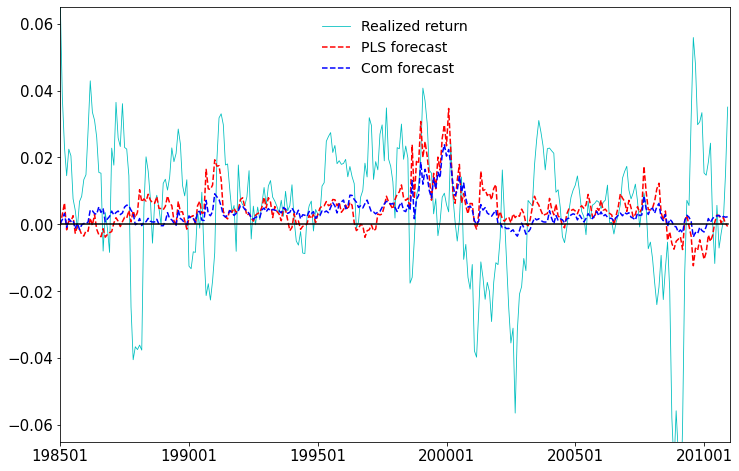

In [47]:
#图2 PLS与Com预测结果对比作图
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
ax.xaxis.set_major_locator(MultipleLocator(60))
xtick=[str(x) for x in forperiod]
plt.ylim(-0.065,0.065)
plt.xlim(0,q)
plt.xticks(size=15)
plt.yticks(size=15)
plt.plot(xtick,df_ret.loc[forperiod,'Rm'].rolling(window=6,min_periods=1).mean(),'c-',linewidth=0.8,
         label='Realized return')#预测区间实际股票回报
plt.plot(xtick,df_Rmf['PLS'],'r--',label='PLS forecast')
plt.plot(xtick,df_Rmf['Com'],'b--',label='Com forecast')
plt.plot(xtick,np.zeros(q),'k-')
plt.legend(loc=9,fontsize=14,frameon=False)
#plt.savefig('Figure2',dpi=500,pad_inches=0.0)
plt.show()

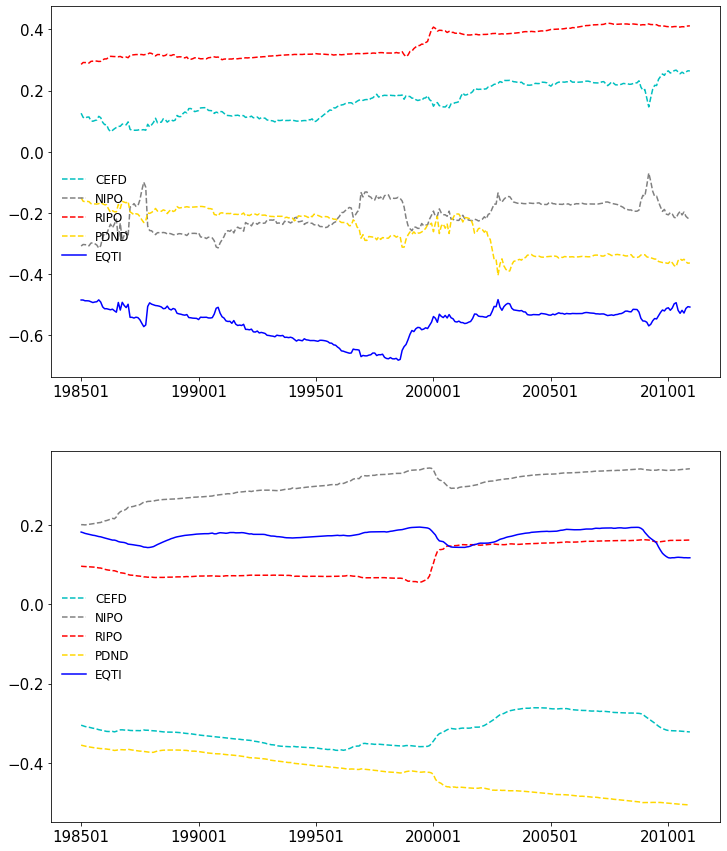

In [49]:
#图3 PLS和BW情绪指数中各单项指标权重变化
w_pls=np.zeros(5)#以矩阵的形式储存权重值
w_bw=np.zeros(5)
for i in range(q):
    period=df_forc.index[:p+i]
    y1=plss[i]
    y2=bws[i]
    x=df_forc.loc[period,['CEFD','NIPO','RIPO1','PDND1','EQTI']]
    params1=sma.OLS(y1,x).fit().params.values#OLS回归获得权重值
    params2=sma.OLS(y2,x).fit().params.values
    w_pls=np.vstack((w_pls,params1))#不断向下更新权重值
    w_bw=np.vstack((w_bw,params2))
fig=plt.figure(figsize=(12,15))
ax1=fig.add_subplot(211)
plt.xticks(size=15)
plt.yticks(size=15)
ax2=fig.add_subplot(212)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.xaxis.set_major_locator(MultipleLocator(60))
ax1.plot(xtick,w_pls[1:,0],'c--',label='CEFD')
ax1.plot(xtick,w_pls[1:,1],'--',color='grey',label='NIPO')
ax1.plot(xtick,w_pls[1:,2],'r--',label='RIPO')
ax1.plot(xtick,w_pls[1:,3],'--',color='gold',label='PDND')
ax1.plot(xtick,w_pls[1:,4],'b-',label='EQTI')
ax1.legend(loc=3,bbox_to_anchor=(0,0.28),fontsize=12,frameon=False)
ax2.xaxis.set_major_locator(MultipleLocator(60))
ax2.plot(xtick,w_bw[1:,0],'c--',label='CEFD')
ax2.plot(xtick,w_bw[1:,1],'--',color='grey',label='NIPO')
ax2.plot(xtick,w_bw[1:,2],'r--',label='RIPO')
ax2.plot(xtick,w_bw[1:,3],'--',color='gold',label='PDND')
ax2.plot(xtick,w_bw[1:,4],'b-',label='EQTI')
ax2.legend(loc=6,fontsize=12,frameon=False)
#plt.savefig('Figure3',dpi=500,pad_inches=0.0)
plt.show()

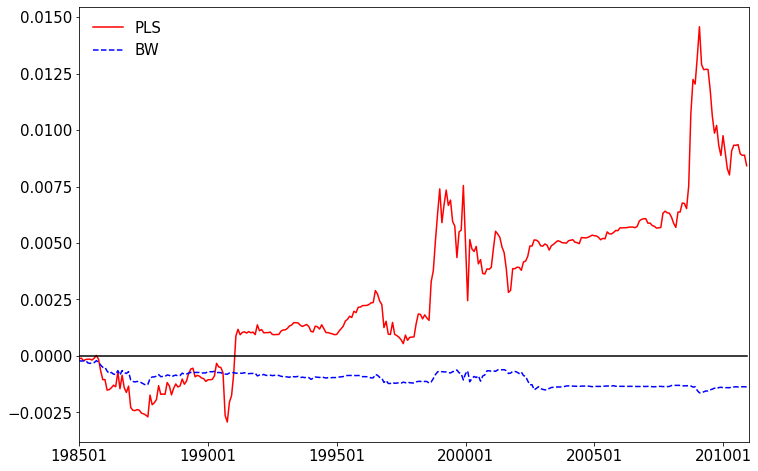

In [50]:
#图4 累计平方误差变化
pls_cses=[]
bw_cses=[]
#按天循环累加预测区间的平方预测误差
for i in range(q):
    pls_cse=np.sum(seh[0:i+1]-mat_sef[3,0:i+1])
    bw_cse=np.sum(seh[0:i+1]-mat_sef[0,0:i+1])
    pls_cses.append(pls_cse)
    bw_cses.append(bw_cse)
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
ax.xaxis.set_major_locator(MultipleLocator(60))
ax.plot(xtick,pls_cses,'r-',label='PLS')    
ax.plot(xtick,bw_cses,'b--',label='BW')
ax.plot(xtick,np.zeros(q),'k-')
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlim(0,q)
plt.legend(loc=2,fontsize=15,frameon=False)
#plt.savefig('Figure4',dpi=500,pad_inches=0.0)
plt.show()

In [51]:
data_sentiment = pd.read_excel('data_sentiment.xlsx')
data_economic = pd.read_excel('data3.xlsx')

#生成回归需要的变量
S_PLS = data_sentiment[['yyyymm','PLS']]
S_BW = data_sentiment[['yyyymm','BW']]
R_m = data_economic[['yyyymm','Rm']]

SPLS_lag_1 = S_PLS.shift(1);SPLS_lag_1 = SPLS_lag_1.dropna();
SPLS_lag_3 = S_PLS.shift(3);SPLS_lag_3 = SPLS_lag_3.dropna();
SPLS_lag_6 = S_PLS.shift(6);SPLS_lag_6 = SPLS_lag_6.dropna();
SPLS_lag_9 = S_PLS.shift(9);SPLS_lag_9 = SPLS_lag_9.dropna();
SPLS_lag_12 = S_PLS.shift(12);SPLS_lag_12 = SPLS_lag_12.dropna();
SPLS_lag_24 = S_PLS.shift(24);SPLS_lag_24 = SPLS_lag_24.dropna();

SBW_lag_1 = S_BW.shift(1);SBW_lag_1 = SBW_lag_1.dropna();
SBW_lag_3 = S_BW.shift(3);SBW_lag_3 = SBW_lag_3.dropna();
SBW_lag_6 = S_BW.shift(6);SBW_lag_6 = SBW_lag_6.dropna();
SBW_lag_9 = S_BW.shift(9);SBW_lag_9 = SBW_lag_9.dropna();
SBW_lag_12 = S_BW.shift(12);SBW_lag_12 = SBW_lag_12.dropna();
SBW_lag_24 = S_BW.shift(24);SBW_lag_24 = SBW_lag_24.dropna();

R_m_1 = R_m.shift(0);R_m_1 = R_m_1.dropna();
R_m_3 = R_m.shift(-2);R_m_3 = R_m_3.dropna();
R_m_6 = R_m.shift(-5);R_m_6 = R_m_6.dropna();
R_m_9 = R_m.shift(-8);R_m_9 = R_m_9.dropna();
R_m_12 = R_m.shift(-11);R_m_12 = R_m_12.dropna();
R_m_24 = R_m.shift(-23);R_m_24 = R_m_24.dropna();


#3.样本内预测_PLS
results = []#Coefficient, p-value, t-value, r-squared

#1个月预测期
y = list(R_m_1['Rm'])
X = sma.add_constant(list(SPLS_lag_1['PLS']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))


#3个月预测期
y = list(R_m_3['Rm'])
X = sma.add_constant(list(SPLS_lag_3['PLS']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))

#6个月预测期
y = list(R_m_6['Rm'])
X = sma.add_constant(list(SPLS_lag_6['PLS']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))

#9个月预测期
y = list(R_m_9['Rm'])
X = sma.add_constant(list(SPLS_lag_9['PLS']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))

#12个月预测期
y = list(R_m_12['Rm'])
X = sma.add_constant(list(SPLS_lag_12['PLS']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))

#24个月预测期
y = list(R_m_24['Rm'])
X = sma.add_constant(list(SPLS_lag_24['PLS']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))

#进行样本内预测_BW

#1个月预测期
y = list(R_m_1['Rm'])
X = sma.add_constant(list(SBW_lag_1['BW']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))

#3个月预测期
y = list(R_m_3['Rm'])
X = sma.add_constant(list(SBW_lag_3['BW']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))

#6个月预测期
y = list(R_m_6['Rm'])
X = sma.add_constant(list(SBW_lag_6['BW']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))

#9个月预测期
y = list(R_m_9['Rm'])
X = sma.add_constant(list(SBW_lag_9['BW']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))

#12个月预测期
y = list(R_m_12['Rm'])
X = sma.add_constant(list(SBW_lag_12['BW']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))

#24个月预测期
y = list(R_m_24['Rm'])
X = sma.add_constant(list(SBW_lag_24['BW']))
model = sma.OLS(y, X).fit()
t=model.params[1]*100
p=model.pvalues[1]/2
t=str(round(t,2))
if p>=0.05 and p<0.1:
    t=t+'*'
elif p>=0.01 and p<0.05:
    t=t+'**'
elif p<0.01:
    t=t+'***'
results.append(t)
results.append(round(model.tvalues[1],2))
#results.append(model.pvalues[1])
results.append(round(model.rsquared*100,2))

In [53]:
#表6 长期预测
df_in_sample = pd.DataFrame(np.reshape(results,(12,3)),index = ['1month','3month','6month','9month','12month','24month',    '1month','3month','6month','9month','12month','24month'], columns = ['beta','t-value','R-squared'])
df_in_sample_PLS = df_in_sample.iloc[:6,:]
df_in_sample_PLS = df_in_sample_PLS.rename(columns={'beta':'beta_PLS'}) 
df_in_sample_BW = df_in_sample.iloc[6:,:]
df_in_sample_BW = df_in_sample_BW.rename(columns={'beta':'beta_BW'}) 
df_in_sample = pd.concat([df_in_sample_PLS, df_in_sample_BW], axis = 1)

df_in_sample
#df_in_sample.to_excel('Table6.xlsx')

In [54]:
data_sentiment = pd.read_excel('data_sentiment.xlsx')
data_economic = pd.read_excel('data3.xlsx')
data_forecast = pd.read_excel('data_forecast.xlsx')

In [55]:
def CER_cal(Rm_forecast, Rm, Rf, transaction_cost, gamma):
    Rm_forecast = Rm_forecast
    Rm_real = Rm
    Rf = Rf
    cost = transaction_cost
    gamma = gamma    
    #根据Rm_real的5年移动窗口计算出var_t+1
    row_begin_1 = Rm_real[Rm_real['yyyymm']==198001].index[0]
    var_forecast = Rm_real.iloc[row_begin_1:,:].copy()
    var_forecast['Rm'] = var_forecast['Rm'].rolling(60).var().shift(1)#没有copy之后进行操作，居然在原数组上进行了修改
    var_forecast = var_forecast.dropna().rename(columns={'Rm':'var'})   
    #交易成本为0时资产组合
    if cost == 0:
        #根据Rm_forecast,var_t+1,gamma计算出w_t,R_p_t+1
        w_t = []
        R_p = []
        R_p_excess = []#计算夏普比率使用的指标: 超额回报率
        row_begin_2 = Rm_real[Rm_real['yyyymm']==198501].index[0]
        Rm_real_85to10 = Rm_real.iloc[row_begin_2:,:].copy()
        for i in range(0,312):
            w_t.append(1/gamma * Rm_forecast.iloc[i,1]/var_forecast.iloc[i,1]) #这里根据不同的预测有PLS, BW, EW, Com
            if w_t[i] < 0:
                w_t[i] = 0
            elif w_t[i] > 1.5:
                w_t[i] = 1.5
            R_p.append(w_t[i] * Rm_real_85to10.iloc[i,1] + Rf.iloc[i,1])
            #平均超额回报率
            R_p_excess.append(w_t[i] * Rm_real_85to10.iloc[i,1])
        #根据Rm_forecast计算出R_forecast_naive
        Rm_forecast_naive = Rm_forecast.iloc[:,:2]
        for i in range(0,312):
            Rm_forecast_naive.iloc[i,1] = np.mean(Rm_real.iloc[0:233+i,1])
        #根据Rm_forecast_naive,var_t+1,gamma计算出w_t,R_p_t+1
        w_naive_t = []
        R_p_naive = []
        for i in range(0,312):
            w_naive_t.append(1/gamma * Rm_forecast_naive.iloc[i,1]/var_forecast.iloc[i,1]) #这里根据不同的预测有PLS, BW, EW, Com
            if w_naive_t[i] < 0:
                w_naive_t[i] = 0
            elif w_naive_t[i] > 1.5:
                w_naive_t[i] = 1.5
            R_p_naive.append(w_naive_t[i] * Rm_real.iloc[row_begin_2+i,1] + Rf.iloc[i,1])     
        #计算不同投资组合的确定性等价收益的差值
        CER_p = np.average(R_p) - 0.5 * gamma * np.var(R_p)
        CER_naive = np.average(R_p_naive) - 0.5 * gamma * np.var(R_p_naive)
        CER_delta = (CER_p - CER_naive)*12
        #计算夏普比率
        sharp_ratio = np.mean(R_p_excess) / np.std(R_p_excess)    
    #交易成本不为0时的投资组合
    else:
         #根据Rm_forecast,var_t+1,gamma计算出w_t,R_p_t+1
        w_t = []
        R_p = []
        R_p_excess = []#计算夏普比率使用的指标: 超额回报率
        row_begin_2 = Rm_real[Rm_real['yyyymm']==198501].index[0]
        Rm_real_85to10 = Rm_real.iloc[row_begin_2:,:].copy()
        for i in range(0,312):
            w_t.append(1/gamma * Rm_forecast.iloc[i,1]/var_forecast.iloc[i,1]) #这里根据不同的预测有PLS, BW, EW, Com       
            if w_t[i] < 0:
                w_t[i] = 0
            elif w_t[i] > 1.5:
                w_t[i] = 1.5               
            if i < 1:
                R_p.append(w_t[i] * Rm_real_85to10.iloc[i,1] + Rf.iloc[i,1])

                #平均超额回报率
                R_p_excess.append(w_t[i] * Rm_real_85to10.iloc[i,1])
                
            if i > 1:
                if w_t[i] == w_t[i-1]:
                    R_p.append(w_t[i] * Rm_real_85to10.iloc[i,1] + Rf.iloc[i,1])

                    #平均超额回报率
                    R_p_excess.append(w_t[i] * Rm_real_85to10.iloc[i,1])
                else:
                    R_p.append((w_t[i] * Rm_real_85to10.iloc[i,1] + Rf.iloc[i,1]) * (1-cost/10000))

                    #平均超额回报率
                    R_p_excess.append((w_t[i] * Rm_real_85to10.iloc[i,1]) * (1-cost/10000))       
        #根据Rm_forecast计算出R_forecast_naive
        Rm_forecast_naive = Rm_forecast.iloc[:,:2]
        for i in range(0,312):
            Rm_forecast_naive.iloc[i,1] = np.mean(Rm_real.iloc[0:233+i,1])
        #根据Rm_forecast_naive,var_t+1,gamma计算出w_t,R_p_t+1
        w_naive_t = []
        R_p_naive = []
        for i in range(0,312):
            w_naive_t.append(1/gamma * Rm_forecast_naive.iloc[i,1]/var_forecast.iloc[i,1]) #这里根据不同的预测有PLS, BW, EW, Com
            if w_naive_t[i] < 0:
                w_naive_t[i] = 0
            elif w_naive_t[i] > 1.5:
                w_naive_t[i] = 1.5           
            if i < 1:
                R_p_naive.append(w_naive_t[i] * Rm_real_85to10.iloc[i,1] + Rf.iloc[i,1])                
            if i > 1:
                if w_naive_t[i] == w_naive_t[i-1]:
                    R_p_naive.append(w_naive_t[i] * Rm_real_85to10.iloc[i,1] + Rf.iloc[i,1])
                else:
                    R_p_naive.append((w_naive_t[i] * Rm_real_85to10.iloc[i,1] + Rf.iloc[i,1]) * (1-cost/10000))
            R_p_naive.append(w_naive_t[i] * Rm_real.iloc[row_begin_2+i,1] + Rf.iloc[i,1])     
        #计算不同投资组合的确定性等价收益的差值
        CER_p = np.average(R_p) - 0.5 * gamma * np.var(R_p)
        CER_naive = np.average(R_p_naive) - 0.5 * gamma * np.var(R_p_naive)
        CER_delta = (CER_p - CER_naive)*12
        #计算夏普比率
        sharp_ratio = np.mean(R_p_excess) / np.std(R_p_excess)    
    return [CER_delta, sharp_ratio, cost, gamma]

In [57]:
#表7资产配置结果
result = []
for cost in [0, 50]:
    for gamma in [1,3,5]:
        for name in ['BW', 'EW', 'Com', 'PLS']:
            result.extend(CER_cal(Rm_forecast = data_forecast[['yyyymm', name]], Rm = data_economic[['yyyymm', 'Rm']],Rf = data_forecast[['yyyymm','Rf']], transaction_cost = cost, gamma = gamma))
result = pd.DataFrame(np.reshape(result,(24,4)),columns = ['CER gain(%)','Sharpe ratio','Transaction cost','Gamma'],index = ['S_BW','S_EW','S_Com','S_PLS'] * 6)
result
#result.to_excel( 'Table7.xlsx')

,CER gain(%),Sharpe ratio,Transaction cost,Gamma
S_BW,0.010104,0.088351,0.0,1.0
S_EW,0.020839,0.102498,0.0,1.0
S_Com,0.017413,0.105181,0.0,1.0
S_PLS,0.025112,0.118247,0.0,1.0
S_BW,-0.001005,0.065890,0.0,3.0
S_EW,-0.003959,0.057977,0.0,3.0
S_Com,0.018194,0.103623,0.0,3.0
S_PLS,0.032398,0.133120,0.0,3.0
S_BW,-0.006587,0.051381,0.0,5.0
S_EW,-0.010012,0.038031,0.0,5.0


In [4]:
data_sentiment = pd.read_excel('data5.xlsx')
data_industry = pd.read_csv('Industry_Portfolios.csv',skiprows=11)
data_size = pd.read_csv('Size_Portfolios.csv',skiprows=12)
data_bm = pd.read_csv( 'BM_Portfolios.csv',skiprows=23)
data_momentum = pd.read_csv('Momentum_Portfolios.csv',skiprows=10)

In [5]:
#截取本部分回归所需要的数据
row_begin = data_industry[data_industry['Date'] == '196507'].index[0]
row_end = data_industry[data_industry['Date'] == '201012'].index[0]
data_industry = data_industry.iloc[row_begin:row_end+1,:]

row_begin = data_size[data_size['Date'] == '196507'].index[0]
row_end = data_size[data_size['Date'] == '201012'].index[0]
data_size = data_size.iloc[row_begin:row_end+1,:]

row_begin = data_bm[data_bm['Date'] == '196507'].index[0]
row_end = data_bm[data_bm['Date'] == '201012'].index[0]
data_bm = data_bm.iloc[row_begin:row_end+1,:]

row_begin = data_momentum[data_momentum['Date'] == '196507'].index[0]
row_end = data_momentum[data_momentum['Date'] == '201012'].index[0]
data_momentum = data_momentum.iloc[row_begin:row_end+1,:]

In [6]:
data_sentiment = data_sentiment[['yearmo','PLS','BW']]
data_industry['Date'] = data_industry['Date'].apply(pd.to_numeric)
data_industry_PLS = pd.merge(data_industry,data_sentiment, left_on = 'Date', right_on = 'yearmo')
data_industry_PLS[['yearmo','PLS','BW']] = data_industry_PLS[['yearmo','PLS','BW']].shift(1)
data_industry_PLS = data_industry_PLS.dropna()
data_size['Date'] = data_size['Date'].apply(pd.to_numeric)
data_size_PLS = pd.merge(data_size,data_sentiment, left_on = 'Date', right_on = 'yearmo')
data_size_PLS[['yearmo','PLS','BW']] = data_size_PLS[['yearmo','PLS','BW']].shift(1)
data_size_PLS = data_size_PLS.dropna()
data_bm['Date'] = data_bm['Date'].apply(pd.to_numeric)
data_bm_PLS = pd.merge(data_bm,data_sentiment, left_on = 'Date', right_on = 'yearmo')
data_bm_PLS[['yearmo','PLS','BW']] = data_bm_PLS[['yearmo','PLS','BW']].shift(1)
data_bm_PLS = data_bm_PLS.dropna()
data_momentum['Date'] = data_momentum['Date'].apply(pd.to_numeric)
data_momentum_PLS = pd.merge(data_momentum,data_sentiment, left_on = 'Date', right_on = 'yearmo')
data_momentum_PLS[['yearmo','PLS','BW']] = data_momentum_PLS[['yearmo','PLS','BW']].shift(1)
data_momentum_PLS = data_momentum_PLS.dropna()

In [7]:
data_size_PLS

,Date,<= 0,Lo 30,Med 40,Hi 30,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,...,4-Dec,5-Dec,6-Dec,7-Dec,8-Dec,9-Dec,Hi 10,yearmo,PLS,BW
1,196508,-99.99,4.21,5.14,2.78,4.22,4.8,6.1,4.19,2.65,...,5.25,7.33,5.26,4.02,4.29,3.47,2.48,196507.0,-1.185905,-1.914807
2,196509,-99.99,2.67,3.42,3.18,2.64,3.97,3.39,3.06,3.19,...,4.88,3.48,3.32,2.96,3.12,2.85,3.26,196508.0,-0.241271,-1.924326
3,196510,-99.99,6.85,4.72,2.56,7.45,5.85,5.21,3.9,2.42,...,6,5.79,4.81,3.72,4.01,3.62,2.17,196509.0,-0.145312,-1.817766
4,196511,-99.99,4.86,4.37,-0.39,5.92,4.87,4.44,3.35,-0.72,...,6.48,5.31,3.81,3.55,3.22,1.56,-1.2,196510.0,-0.288022,-1.656621
5,196512,-99.99,4.54,3.23,0.94,4.58,5.01,2.79,2.09,0.88,...,5.4,2.18,3.23,2.94,1.58,1.8,0.68,196511.0,0.241910,-1.674017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,201008,-99.99,-8.49,-5.96,-4.39,-8.93,-7.33,-6.23,-4.75,-4.37,...,-6.96,-7.35,-5.46,-5.07,-4.58,-4.39,-4.37,201007.0,0.108823,-0.286376
542,201009,-99.99,12.18,12.04,9.07,11.7,13.36,12.66,10.75,8.88,...,13.72,12.83,12.54,10.33,10.98,10.39,8.55,201008.0,0.425315,-0.204588
543,201010,-99.99,4.8,3.2,3.92,5.28,3.32,4.05,3.49,3.9,...,2.72,4.08,4.03,2.22,4.15,3.67,3.95,201009.0,0.267285,-0.200580
544,201011,-99.99,3.71,3.39,0.13,3.83,3.67,4.06,2.93,-0.21,...,3.79,4.33,3.87,2.21,3.3,1.37,-0.55,201010.0,0.592510,-0.323063


In [17]:
def signif2(result,i):
    beta=str(round(result.params[i]*1000,2))
    p=result.pvalues[i]/50
    if p>=0.05 and p<0.1:
        beta=beta+'*'
    elif p>=0.01 and p<0.05:
        beta=beta+'**'
    elif p<0.01:
        beta=beta+'***'
    return beta
def signif3(result,i):
    beta=str(round(result.params[i]*10000,2))
    p=result.pvalues[i]/50
    if p>=0.05 and p<0.1:
        beta=beta+'*'
    elif p>=0.01 and p<0.05:
        beta=beta+'**'
    elif p<0.01:
        beta=beta+'***'
    return beta
def signif4(result,i):
    beta=str(round(result.params[i]*100000,2))
    p=result.pvalues[i]/50
    if p>=0.05 and p<0.1:
        beta=beta+'*'
    elif p>=0.01 and p<0.05:
        beta=beta+'**'
    elif p<0.01:
        beta=beta+'***'
    return beta

In [72]:
results_industry = []#Coefficient, p-value, t-value, r-squared

for i in range(1,11):
    y = list(data_industry_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_industry_PLS['PLS']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_industry.append(t)
    results_industry.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_industry.append(round(model.rsquared*100,2))

for i in range(1,11):
    y = list(data_industry_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_industry_PLS['BW']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_industry.append(t)
    results_industry.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_industry.append(round(model.rsquared*100,2))

In [73]:
results_size = []#Coefficient, p-value, t-value, r-squared

for i in range(10,20):
    y = list(data_size_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_size_PLS['PLS']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_size.append(t)
    results_size.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_size.append(round(model.rsquared*100,2))

for i in range(10,20):
    y = list(data_size_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_size_PLS['BW']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_size.append(t)
    results_size.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_size.append(round(model.rsquared*100,2))

In [74]:
results_bm = []#Coefficient, p-value, t-value, r-squared

for i in range(10,20):
    y = list(data_bm_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_bm_PLS['PLS']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_bm.append(t)
    results_bm.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_bm.append(round(model.rsquared*100,2))

for i in range(10,20):
    y = list(data_bm_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_bm_PLS['BW']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_bm.append(t)
    results_bm.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_bm.append(round(model.rsquared*100,2))

In [75]:
results_momentum = []#Coefficient, p-value, t-value, r-squared

for i in range(1,11):
    y = list(data_momentum_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_momentum_PLS['PLS']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_momentum.append(t)
    results_momentum.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_momentum.append(round(model.rsquared*100,2))

for i in range(1,11):
    y = list(data_momentum_PLS.iloc[:,i].apply(pd.to_numeric))
    X = sma.add_constant(list(data_momentum_PLS['BW']))
    model = sma.OLS(y, X).fit()
    t=model.params[1]
    p=model.pvalues[1]/2
    t=str(round(t,2))
    if p>=0.05 and p<0.1:
        t=t+'*'
    elif p>=0.01 and p<0.05:
        t=t+'**'
    elif p<0.01:
        t=t+'***'
    results_momentum.append(t)
    results_momentum.append(round(model.tvalues[1],2))
    #results.append(model.pvalues[1])
    results_momentum.append(round(model.rsquared*100,2))


In [77]:
df_industry = pd.DataFrame(np.reshape(results_industry,(20,3)),columns=['beta', 't-value', 'R-squared'])
df_size = pd.DataFrame(np.reshape(results_size,(20,3)),columns=['beta', 't-value', 'R-squared'])
df_bm = pd.DataFrame(np.reshape(results_bm,(20,3)),columns=['beta', 't-value', 'R-squared'])
df_momentum = pd.DataFrame(np.reshape(results_momentum,(20,3)),columns=['beta', 't-value', 'R-squared'])

df = pd.concat([df_industry, df_size, df_bm, df_momentum],axis = 0)

df.index = ['NoDurable','Durable','Manufacture','Energy','Technology','Telecom','Shop','Health','Utility','Other','NoDurable','Durable','Manufacture','Energy','Technology','Telecom','Shop','Health','Utility','Other','Small','2','3','4','5','6','7','8','9','Large','Small','2','3','4','5','6','7','8','9','Large','Growth','2','3','4','5','6','7','8','9','Value','Growth','2','3','4','5','6','7','8','9','Value', 'Loser','2','3','4','5','6','7','8','9','Winner','Loser','2','3','4','5','6','7','8','9','Winner']

df_PLS_industry = df.iloc[0:10,:];df_PLS_industry = df_PLS_industry.rename(columns={'beta':'beta_PLS'}) 
df_BW_industry  = df.iloc[10:20,:];df_BW_industry = df_BW_industry.rename(columns={'beta':'beta_BW'}) 
df_PLS_size = df.iloc[20:30,:];df_PLS_size = df_PLS_size.rename(columns={'beta':'beta_PLS'}) 
df_BW_size  = df.iloc[30:40,:];df_BW_size = df_BW_size.rename(columns={'beta':'beta_BW'}) 
df_PLS_bm  = df.iloc[40:50,:];df_PLS_bm = df_PLS_bm.rename(columns={'beta':'beta_PLS'}) 
df_BW_bm  = df.iloc[50:60,:];df_BW_bm = df_BW_bm.rename(columns={'beta':'beta_BW'}) 
df_PLS_momentum  = df.iloc[60:70,:];df_PLS_momentum = df_PLS_momentum.rename(columns={'beta':'beta_PLS'}) 
df_BW_momentum  = df.iloc[70:80,:];df_BW_momentum = df_BW_momentum.rename(columns={'beta':'beta_BW'})

df_industry = pd.concat([df_PLS_industry, df_BW_industry], axis = 1)
df_size = pd.concat([df_PLS_size, df_BW_size], axis = 1)
df_bm = pd.concat([df_PLS_bm, df_BW_bm], axis = 1)
df_momentum = pd.concat([df_PLS_momentum, df_BW_momentum], axis = 1)

df =  pd.concat([df_industry, df_size, df_bm, df_momentum], axis = 0)
df
#df.to_excel('Table8.xlsx')

In [12]:
df = pd.read_excel('SP500.xlsx')
df["year"] = list(map(lambda x: str(x)[:4], df["Data Date - Index Monthly"]))
dividend = pd.DataFrame(df.groupby(["year"]).apply(lambda x: x["Dividend"].mean()), columns = ["Dividend_Year"]).reset_index()
temp = [np.nan]
temp.extend(np.diff(np.log(dividend["Dividend_Year"])).tolist())
dividend["DG"] = temp
df = pd.merge(left = df, right = dividend, on = ["year"], how = "inner")

df["year"] = list(map(lambda x: str(x)[:4], df["Data Date - Index Monthly"]))
dividend = pd.DataFrame(df.groupby(["year"]).apply(lambda x: x["Earnings"].mean()), columns = ["Earnings_Year"]).reset_index()
temp = [np.nan]
temp.extend(np.diff(np.log(dividend["Earnings_Year"])).tolist())
dividend["EG"] = temp
df = pd.merge(left = df, right = dividend, on = ["year"], how = "inner")

df["year"] = list(map(lambda x: str(x)[:4], df["Data Date - Index Monthly"]))
dividend = pd.DataFrame(df.groupby(["year"]).apply(lambda x: x["Price"].mean()), columns = ["Price_Year"]).reset_index()


df["DP"] = np.log(df["Price"] / df["Dividend"])
#df.to_excel("data4part.xlsx")

In [59]:
data = pd.read_excel('data4.xlsx')
#data.head() #查看数据头5行
data['lagDP'] = data['DP'].shift(1) #生成滞后一期解释变量
data['lagPLS'] = data['PLS'].shift(1) 
data['lagBW'] = data['BW'].shift(1) 
data

,Unnamed: 0,Data Date Monthly,year,DG,EG,DP,GDPG,BW,PLS,lagDP,lagPLS,lagBW
0,1,1965-12-31,1965,NaN,NaN,5.835785,NaN,-1.688123,0.241910,NaN,NaN,NaN
1,2,1966-12-31,1966,-6.250001e-08,0.084240,5.733217,-0.007701,-1.175593,0.077018,5.835785,0.241910,-1.688123
2,3,1967-12-31,1967,2.061927e-02,-0.002934,5.916306,0.013652,-0.351754,-3.350537,5.733217,0.077018,-1.175593
3,4,1968-12-31,1968,4.976164e-02,0.026851,5.916009,-0.000022,2.145583,-0.280910,5.916306,-3.350537,-0.351754
4,5,1969-12-31,1969,2.871008e-02,0.051203,5.795406,-0.008945,3.099287,2.937687,5.916009,-0.280910,2.145583
5,6,1970-12-31,1970,-1.904818e-02,-0.054369,5.870491,0.005591,0.609697,0.907846,5.795406,2.937687,3.099287
6,7,1971-12-31,1971,-9.661902e-03,-0.036133,5.972928,0.007513,-0.849604,-0.205574,5.870491,0.907846,0.609697
7,8,1972-12-31,1972,1.923134e-02,0.113966,6.044074,0.005142,-0.283706,0.985593,5.972928,-0.205574,-0.849604
8,9,1973-12-31,1973,8.223808e-02,0.185390,5.719799,-0.023949,-1.218994,1.770076,6.044074,0.985593,-0.283706
9,10,1974-12-31,1974,5.959204e-02,0.186645,5.367144,-0.027638,-1.997765,-0.332366,5.719799,1.770076,-1.218994


In [60]:
#定义一个不乘以100的显著性标记函数
def signif1(result,i):
    beta=str(round(result.params[i],2))
    p=result.pvalues[i]
    if p>=0.05 and p<0.1:
        beta=beta+'*'
    elif p>=0.01 and p<0.05:
        beta=beta+'**'
    elif p<0.01:
        beta=beta+'***'
    return beta

In [61]:
#表9A 根据PLS投资者情绪预测现金流和贴现率

econ_pre=['DP','DG','EG','GDPG']
betas=[]
tbs=[]
psis=[]
tps=[]
R2s=[]
#循环做二元回归
for econ in econ_pre:
    x=data.loc[:,['lagPLS','lagDP']]
    x=sma.add_constant(x)
    y=data[econ]
    model=sma.OLS(y,x,missing='drop')
    result=model.fit()
    if econ=='DP':
        beta=signif1(result,1)#情绪指标的系数，并带上了显著性
    else:
        beta=signif(result,1)#情绪指标的系数，并带上了显著性
    tb=round(result.tvalues[1],2)
    if econ=='DP':
        psi=signif1(result,2)#情绪指标的系数，并带上了显著性
    else:
        psi=signif(result,2)#情绪指标的系数，并带上了显著性
    tp=round(result.tvalues[2],2)
    R2=round(result.rsquared*100,2)
    betas.append(beta)
    tbs.append(tb)
    psis.append(psi)
    tps.append(tp)
    R2s.append(R2)
table9A=pd.DataFrame(index=econ_pre,columns=['beta(%)','t-stat','psi(%)','t-stat','R2(%)'])
table9A['beta(%)']=betas
table9A.iloc[:,1]=tbs
table9A['psi(%)']=psis
table9A.iloc[:,3]=tps
table9A['R2(%)']=R2s
#table9A.to_excel('Tabel9A.xlsx')
print(table9A)

     beta(%) t-stat   psi(%) t-stat  R2(%)
DP     -0.01   -0.4  0.91***  12.97  81.31
DG     -0.43  -0.53    -1.77  -0.82   1.82
EG      4.36   0.94     9.88   0.81   2.84
GDPG   -0.08  -0.42    -0.67  -1.34   4.12


D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
#表9B 根据BW投资者情绪预测现金流和贴现率


econ_pre=['DP','DG','EG','GDPG']
betas=[]
tbs=[]
psis=[]
tps=[]
R2s=[]
#循环做二元回归
for econ in econ_pre:
    x=data.loc[:,['lagBW','lagDP']]
    x=sma.add_constant(x)
    y=data[econ]
    model=sma.OLS(y,x,missing='drop')
    result=model.fit()
    if econ=='DP':
        beta=signif1(result,1)#情绪指标的系数，并带上了显著性
    else:
        beta=signif(result,1)#情绪指标的系数，并带上了显著性
    tb=round(result.tvalues[1],2)
    if econ=='DP':
        psi=signif1(result,2)#情绪指标的系数，并带上了显著性
    else:
        psi=signif(result,2)#情绪指标的系数，并带上了显著性
    tp=round(result.tvalues[2],2)
    R2=round(result.rsquared*100,2)
    betas.append(beta)
    tbs.append(tb)
    psis.append(psi)
    tps.append(tp)
    R2s.append(R2)
table9B=pd.DataFrame(index=econ_pre,columns=['beta(%)','t-stat','psi(%)','t-stat','R2(%)'])
table9B['beta(%)']=betas
table9B.iloc[:,1]=tbs
table9B['psi(%)']=psis
table9B.iloc[:,3]=tps
table9B['R2(%)']=R2s
#table9B.to_excel('Tabel9B.xlsx')
print(table9B)

     beta(%) t-stat   psi(%) t-stat  R2(%)
DP      -0.0  -0.15  0.92***  13.19  81.25
DG      -1.1  -1.32    -0.86  -0.41   5.08
EG     -6.06  -1.27    10.37   0.87   4.48
GDPG   -0.01  -0.04    -0.61  -1.23   3.72


D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [31]:
data = pd.read_excel('data7.xlsx')
data

,date,Small,sec,thi,for,fif,six,sev,eig,nin,Large,lagPLS,lagBW
0,196508,0.550943,0.315789,0.206304,0.556851,1.172107,0.522857,0.451852,0.186992,0.437500,1.209091,-1.185905,-1.914807
1,196509,-0.265207,-0.493333,-0.377672,-0.102996,-0.510929,-0.390244,-0.239796,-0.285388,-0.171014,0.329218,-0.241271,-1.924326
2,196510,1.665563,1.921053,1.213740,0.275574,0.583799,0.489231,0.241611,0.313099,0.188811,-0.325077,-0.145312,-1.817766
3,196511,-0.110559,-0.373874,-0.479310,0.011457,-0.067019,-0.212810,-0.035135,-0.231144,-0.502941,-1.559633,-0.288022,-1.656621
4,196512,-0.275140,-0.122302,0.500000,-0.152104,-0.559546,-0.175853,-0.145658,-0.484177,0.076923,-1.540984,0.241910,-1.674017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,201008,-2.576147,-2.444099,-2.121429,-1.991189,-1.960000,-1.834101,-1.741007,-1.611559,-1.591922,-1.640876,0.108823,-0.286376
541,201009,-2.289872,-2.302151,-2.629299,-3.002963,-2.771505,-3.302026,-3.011650,-3.439560,-3.421176,-2.947608,0.425315,-0.204588
542,201010,-0.591155,-0.511974,-0.663800,-0.786982,-0.682094,-0.663200,-0.813707,-0.634234,-0.652089,-0.536842,0.267285,-0.200580
543,201011,-0.441501,-0.192893,-0.197674,0.354167,0.021480,-0.052257,0.150259,-0.229064,-0.670391,-1.141414,0.592510,-0.323063


In [45]:
#表10B_PLS 横断面关系PLS

econ_pre=['Small','sec','thi','for','fif','six','sev','eig','nin','Large']
betas=[]
tbs=[]
R2s=[]
#循环做二元回归
for econ in econ_pre:
    x=data.loc[:,['lagPLS']]
    x=sma.add_constant(x)
    y=data[econ]
    model=sma.OLS(y,x,missing='drop')
    result=model.fit()
    beta=round(result.params[1],2)
    tb=round(result.tvalues[1],2)
    R2=round(result.rsquared*100,2)
    betas.append(beta)
    tbs.append(tb)

    R2s.append(R2)
table10B_PLS=pd.DataFrame(index=econ_pre,columns=['psi','t-stat','R2(%)'])
table10B_PLS['psi']=betas
table10B_PLS.iloc[:,1]=tbs
table10B_PLS['R2(%)']=R2s
#table10B_PLS.to_excel('Tabel10B_PLS.xlsx')
print(table10B_PLS)

        psi  t-stat  R2(%)
Small -5.26   -1.45   0.38
sec    0.39    0.27   0.01
thi   -1.29   -3.03   1.66
for   -0.94   -1.74   0.56
fif   -0.13   -0.24   0.01
six    0.34    0.33   0.02
sev    0.82    1.92   0.67
eig    0.49    0.67   0.08
nin    0.38    0.51   0.05
Large -1.07   -0.60   0.07


D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [46]:
#表10B_BW 横断面关系BW

econ_pre=['Small','sec','thi','for','fif','six','sev','eig','nin','Large']
betas=[]
tbs=[]
R2s=[]
#循环做二元回归
for econ in econ_pre:
    x=data.loc[:,['lagBW']]
    x=sma.add_constant(x)
    y=data[econ]
    model=sma.OLS(y,x,missing='drop')
    result=model.fit()
    beta=round(result.params[1],2)
    tb=round(result.tvalues[1],2)
    R2=round(result.rsquared*100,2)
    betas.append(beta)
    tbs.append(tb)

    R2s.append(R2)
table10B_BW=pd.DataFrame(index=econ_pre,columns=['psi','t-stat','R2(%)'])
table10B_BW['psi']=betas
table10B_BW.iloc[:,1]=tbs
table10B_BW['R2(%)']=R2s
#table10B_BW.to_excel('Tabel10B_BW.xlsx')
print(table10B_BW)

        psi  t-stat  R2(%)
Small  4.03    1.19   0.26
sec   -0.05   -0.04   0.00
thi   -0.22   -0.55   0.06
for   -0.55   -1.10   0.22
fif   -0.45   -0.89   0.15
six    0.39    0.40   0.03
sev    0.10    0.25   0.01
eig    0.54    0.79   0.11
nin    0.60    0.86   0.14
Large -1.17   -0.71   0.09


D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [47]:
df_A = pd.read_excel('data8.xlsx')
betas=[]
tbs=[]
R2s=[]
Y=['PLS_beta']
X=['PLS_psi']
y=df_A[Y]
x=df_A[X]
model=sma.OLS(y,x,missing='drop')
result=model.fit()
beta=round(result.params[0],2)
tb=round(result.tvalues[0],2)
R2=round(result.rsquared*100,2)
betas.append(beta)
tbs.append(tb)
R2s.append(R2)
table10A_PLS=pd.DataFrame(index=['PLS'],columns=['g','t-stat','R2(%)'])
table10A_PLS['g']=betas
table10A_PLS.iloc[:,1]=tbs
table10A_PLS['R2(%)']=R2s
#table10A_PLS.to_excel('Tabel10A_PLS.xlsx')
print(table10A_PLS)

        g  t-stat  R2(%)
PLS  0.18    5.43  76.63


In [48]:
df_A = pd.read_excel('data8.xlsx')
betas=[]
tbs=[]
R2s=[]
Y=['BW_beta']
X=['BW_psi']
y=df_A[Y]
x=df_A[X]
model=sma.OLS(y,x,missing='drop')
result=model.fit()
beta=result.params[0]
tb=round(result.tvalues[0],2)
R2=round(result.rsquared*100,2)
betas.append(beta)
tbs.append(tb)
R2s.append(R2)
table10A_BW=pd.DataFrame(index=['BW'],columns=['beta(%)','t-stat','R2(%)'])
table10A_BW['beta(%)']=betas
table10A_BW.iloc[:,1]=tbs
table10A_BW['R2(%)']=R2s
#table10A_BW.to_excel('Tabel10A_BW.xlsx')
print(table10A_BW)

     beta(%)  t-stat  R2(%)
BW  0.091934   17.63  97.18


In [16]:
df = pd.read_excel('data6.xlsx')
average_earnings = pd.DataFrame(df.groupby(["Data Year"]).apply(lambda x: (x['Operating Income After Depreciation'].sum()/len(x['Operating Income After Depreciation'].values)))).reset_index()
average_earnings.rename(columns={average_earnings.columns[-1]:'Operating Income After Depreciation'},inplace=True)
average_earnings.head()

average_currentassets = pd.DataFrame(df.groupby(["Data Year"]).apply(lambda x: (x['Current Assets'].sum()/len(x['Current Assets'].values)))).reset_index()
average_currentassets.rename(columns={average_currentassets.columns[-1]:'Current Assets'},inplace=True)
average_currentassets.head()
average_CurrentLiabilities = pd.DataFrame(df.groupby(["Data Year"]).apply(lambda x: (x['Current Liabilities'].sum()/len(x['Current Liabilities'].values)))).reset_index()
average_CurrentLiabilities.rename(columns={average_CurrentLiabilities.columns[-1]:'Current Liabilities'},inplace=True)
average_CurrentLiabilities.head()

average_Depreciation = pd.DataFrame(df.groupby(["Data Year"]).apply(lambda x: (x['Depreciation and Amortization'].sum()/len(x['Depreciation and Amortization'].values)))).reset_index()
average_Depreciation.rename(columns={average_Depreciation.columns[-1]:'Depreciation and Amortization'},inplace=True)
average_Depreciation.head()

temp = pd.concat([average_earnings, average_currentassets, average_CurrentLiabilities, average_Depreciation], axis = 1)
temp = temp.loc[:, ~temp.columns.duplicated()]
#temp.to_excel("data9part.xlsx")

In [18]:
data = pd.read_excel('data9.xlsx')

In [26]:
#表11A总收益
econ_pre=['RETURN1','RETURN3','RETURN6','RETURN12']
betas=[]
tbs=[]
R2s=[]
#循环做二元回归
for econ in econ_pre:
    x=data.loc[:,['Accruals']]
    x=sma.add_constant(x)
    y=data[econ]
    model=sma.OLS(y,x,missing='drop')
    result=model.fit()
    beta=signif3(result,1)
    tb=round(result.tvalues[1],2)
    R2=round(result.rsquared*100,2)
    betas.append(beta)
    tbs.append(tb)
    R2s.append(R2)
table11A=pd.DataFrame(index=econ_pre,columns=['beta(%)','t-stat','R2(%)'])
table11A['beta(%)']=betas
table11A.iloc[:,1]=tbs
table11A['R2(%)']=R2s
#table11A.to_excel('Tabel11A.xlsx')
print(table11A)

           beta(%)  t-stat  R2(%)
RETURN1     1.31**    0.26   0.18
RETURN3   -3.08***   -0.88   1.94
RETURN6    4.38***    1.48   5.35
RETURN12   -0.74**   -0.21   0.12


D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
#表11B总现金流
econ_pre=['RETURN1','RETURN3','RETURN6','RETURN12']
betas=[]
tbs=[]
R2s=[]
#循环做二元回归
for econ in econ_pre:
    x=data.loc[:,['Cashflows']]
    x=sma.add_constant(x)
    y=data[econ]
    model=sma.OLS(y,x,missing='drop')
    result=model.fit()
    beta=signif4(result,1)
    tb=round(result.tvalues[1],2)
    R2=round(result.rsquared*100,2)
    betas.append(beta)
    tbs.append(tb)
    R2s.append(R2)
table11B=pd.DataFrame(index=econ_pre,columns=['beta(%)','t-stat','R2(%)'])
table11B['beta(%)']=betas
table11B.iloc[:,1]=tbs
table11B['R2(%)']=R2s
#table11B.to_excel('Tabel11B.xlsx')
print(table11B)

          beta(%)  t-stat  R2(%)
RETURN1   -5.14**   -0.32   0.27
RETURN3   -1.75**   -0.16   0.06
RETURN6   -1.32**   -0.14   0.05
RETURN12   3.62**    0.33   0.27


D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [29]:
#表11CPLS
econ_pre=['RETURN1','RETURN3','RETURN6','RETURN12']
betas=[]
tbs=[]
R2s=[]
#循环做二元回归
for econ in econ_pre:
    x=data.loc[:,['PLS']]
    x=sma.add_constant(x)
    y=data[econ]
    model=sma.OLS(y,x,missing='drop')
    result=model.fit()
    beta=signif2(result,1)
    tb=round(result.tvalues[1],2)
    R2=round(result.rsquared*100,2)
    betas.append(beta)
    tbs.append(tb)
    R2s.append(R2)
table11C=pd.DataFrame(index=econ_pre,columns=['beta(%)','t-stat','R2(%)'])
table11C['beta(%)']=betas
table11C.iloc[:,1]=tbs
table11C['R2(%)']=R2s
#table11C.to_excel('Tabel11C.xlsx')
print(table11C)

           beta(%)  t-stat  R2(%)
RETURN1     3.95**    0.58   0.87
RETURN3   -9.22***   -2.01   9.39
RETURN6    -1.93**   -0.47   0.56
RETURN12   6.89***    1.50   5.43


D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [3]:
df = pd.read_excel(r'SVAR.xlsx')
df.head() #查看数据头5行

df['lagLVOL'] = df['LVOL'].shift(1) #生成滞后一期解释变量
df['lagPLS'] = df['PLS'].shift(1) 

df.head() #查看数据头5行

#y = df['LVOL']
#Xs = df(['lagPLS', 'lagLVOL'])
m1 = smf.ols(formula = 'LVOL ~ lagPLS+lagLVOL', data=df).fit()
m1.summary() #输出像Stata reg命令后的结果——OLS模型的详细信息


# In[2]:


m2 = smf.ols(formula = 'LVOL ~ lagPLS+lagLVOL', data=df).fit( cov_type='HC1' )
m2.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   LVOL   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     249.5
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           1.56e-77
Time:                        23:01:25   Log-Likelihood:                 297.28
No. Observations:                 545   AIC:                            -588.6
Df Residuals:                     542   BIC:                            -575.7
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3650      0.040      9.156      0.000       0.287       0.443
lagPLS         0.0111      0.006      1.814      0.070      -0.001       0.023
lagLVOL        0.7104      0.032     22.219      0.000       0.648       0.773
==============================================================================
Omnibus:                       53.259   Durbin-Watson:                   2.383
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.517
Skew:                           0.613   Prob(JB):                     1.10e-21
Kurtosis:                       4.657   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""